# Strategic Thinking Final CA3 - Capstone Project 


- Github Link : https://github.com/CCT-Dublin/ca1-capstone-project-proposal-Aline-Menezes-Silva

## Title: Sales Prediction 
### Optimising Sales Performance for a US Candy Distributor


## Problem Statement:
A US-based candy distributor struggles to maximise sales and profits due to inefficient logistics, uneven regional performance, and unclear demand patterns. By analysing customer locations, factory shipments, sales orders, and product details, this project will identify key opportunities to improve revenue—such as predicting demand more accurately, targeting high-value customer groups, and optimising delivery routes to reduce costs. The goal is to provide actionable insights that enhance sales performance while cutting unnecessary expenses.


To increase the Superstore sales, superstore gave us a task to understand what segments, regions, cities or customers they should be focusing on. The goal is to give practical insights to improve profit based on sales.
In the dynamic world of retail, forecasting sales accurately is a critical aspect of optimizing operations, managing inventory, and ensuring profitability. This project revolves around a retail dataset spanning four years from a global superstore. This will done using EDA and Regression Technique

## Data Description

- US Candy Distributor: 
The dataset includes Sales and geospatial factory to customer shipment data for a US national candy distributor, inlcuding information around customer & factory locations, sales orders & goals and product details.

- Candy_Products.csv
- Candy_Sales.csv


#### Data Dictionary 

Most of the fields are self-explanatory.

- Row ID = Unique row identifier
- Order ID = Unique order identifier
- Order Date = Date of order
- Ship Date = Date of shipment
- Ship Mode = Shipping method of order
- Customer ID = Unique customer identifier
- Country/Region = Country or region of customer
- City = City of customer
- State/Province = State/province of customer
- Postal Code = Postal code / zip code of customer
- Division = Product division
- Region = Region of customer
- Product ID = Unique product identifier
- Product Name = Product long name
- Sales = otal sales value of order
- Units = Total units of order
- Gross = Profit	Gross profit of order ( Sales - Cost )
- Cost = Cost to manufacture
- Factory = Factory Name



## Business questions
What are the store performances in the different countries and states?

Which country is the best marketplace to sell road and mountain bikes?

What is the spending by age group and gender?

Which months of the year have the slowest sale?

Hypothesis testing: Is there a gender bias in road bikes sales?

## Objective
Condut a data anaysis, performing EDA and Predict the sales by using Regression ML algorithms!

## Solution:
Perform EDA (Data Analysis,Data Visualization, Data Cleaning) to understand the data and to clean the dataset for further process
Perform data preprocessing
Build pipeline to train and test the ML Regression model
Model Evaluation
Conclusion

## Import Libraries 

plt.savefig("sales_qq_comparison.png", dpi=300, bbox_inches='tight')

In [12]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR         
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import time
from sklearn.linear_model import LassoLars
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns # visualisation, we can get the dataset for demonstration
import pandas as pd # computing numbers/data
import numpy as np # computing numbers/data
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score #
from sklearn.preprocessing import LabelEncoder, StandardScaler # handling categorical data, feature scaling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import missingno as msno


import warnings
warnings.filterwarnings("ignore")

In [13]:
pd.set_option('display.max_columns', None) 

## Reading the Datasets:

In [15]:
candy_products = pd.read_csv("Candy_Products.csv")
candy_products.head(5)

,Division,Product Name,Factory,Product ID,Unit Price,Unit Cost
0,Chocolate,Wonka Bar - Nutty Crunch Surprise,Lot's O' Nuts,CHO-NUT-13000,3.49,1.00
1,Chocolate,Wonka Bar - Fudge Mallows,Lot's O' Nuts,CHO-FUD-51000,3.60,1.20
2,Chocolate,Wonka Bar -Scrumdiddlyumptious,Lot's O' Nuts,CHO-SCR-58000,3.60,1.10
3,Chocolate,Wonka Bar - Milk Chocolate,Wicked Choccy's,CHO-MIL-31000,3.25,1.14
4,Chocolate,Wonka Bar - Triple Dazzle Caramel,Wicked Choccy's,CHO-TRI-54000,3.75,1.30


In [16]:
candy_sales = pd.read_csv("Candy_Sales.csv")
candy_sales.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State/Province,Postal Code,Division,Region,Product ID,Product Name,Sales,Units,Gross Profit,Cost
0,1380,CA-2021-100867-CHO-FUD-51000,19 10 2021,16 11 2021,Standard Class,100867.0,Canada,Vancouver,British Columbia,V6G,Chocolate,Pacific,CHO-FUD-51000,Wonka Bar - Fudge Mallows,10.8,3,7.2,3.6
1,1241,CA-2021-107153-CHO-FUD-51000,28 09 2021,26 10 2021,Standard Class,107153.0,Canada,Montreal,Quebec,H1A,Chocolate,Atlantic,CHO-FUD-51000,Wonka Bar - Fudge Mallows,7.2,2,4.8,2.4


## Merging the two Datasets:

In [18]:
#Merging The Sales and Products Datasets based on Product ID (to extract the Factory Name)

candy_df = pd.merge(candy_products, candy_sales, how='left', on='Product ID')
candy_df.head(5)

,Division_x,Product Name_x,Factory,Product ID,Unit Price,Unit Cost,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State/Province,Postal Code,Division_y,Region,Product Name_y,Sales,Units,Gross Profit,Cost
0,Chocolate,Wonka Bar - Nutty Crunch Surprise,Lot's O' Nuts,CHO-NUT-13000,3.49,1.0,937,CA-2021-115777-CHO-NUT-13000,19 08 2021,14 09 2021,Standard Class,115777.0,Canada,Montreal,Quebec,H1B,Chocolate,Atlantic,Wonka Bar - Nutty Crunch Surprise,3.49,1,2.49,1.0
1,Chocolate,Wonka Bar - Nutty Crunch Surprise,Lot's O' Nuts,CHO-NUT-13000,3.49,1.0,1783,CA-2021-117964-CHO-NUT-13000,2 12 2021,29 12 2021,Standard Class,117964.0,Canada,Moncton,New Brunswick,E1A,Chocolate,Atlantic,Wonka Bar - Nutty Crunch Surprise,24.43,7,17.43,7.0
2,Chocolate,Wonka Bar - Nutty Crunch Surprise,Lot's O' Nuts,CHO-NUT-13000,3.49,1.0,1787,CA-2021-119508-CHO-NUT-13000,4 12 2021,1 01 2022,Standard Class,119508.0,Canada,Vancouver,British Columbia,V6B,Chocolate,Pacific,Wonka Bar - Nutty Crunch Surprise,20.94,6,14.94,6.0
3,Chocolate,Wonka Bar - Nutty Crunch Surprise,Lot's O' Nuts,CHO-NUT-13000,3.49,1.0,1215,CA-2021-160325-CHO-NUT-13000,24 09 2021,17 10 2021,Same Day,160325.0,Canada,Montreal,Quebec,H1C,Chocolate,Atlantic,Wonka Bar - Nutty Crunch Surprise,10.47,3,7.47,3.0
4,Chocolate,Wonka Bar - Nutty Crunch Surprise,Lot's O' Nuts,CHO-NUT-13000,3.49,1.0,1214,CA-2021-160325-CHO-NUT-13000,24 09 2021,17 10 2021,Same Day,160325.0,Canada,Montreal,Quebec,H1C,Chocolate,Atlantic,Wonka Bar - Nutty Crunch Surprise,6.98,2,4.98,2.0


In [19]:
# Dropping duplicated columns (keeping sales dataset versions)

candy_df = candy_df.drop(['Division_y', 'Product Name_y','Unit Price', 'Unit Cost'], axis=1)

# Renaming columns

candy_df = candy_df.rename(columns={
    'Division_x': 'Division',
    'Product Name_x': 'Product Name'
})

## Data Preprocessing:

#### - Check the feature details 

In [22]:
candy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10189 entries, 0 to 10188
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Division        10189 non-null  object 
 1   Product Name    10189 non-null  object 
 2   Factory         10189 non-null  object 
 3   Product ID      10189 non-null  object 
 4   Row ID          10189 non-null  int64  
 5   Order ID        10189 non-null  object 
 6   Order Date      10189 non-null  object 
 7   Ship Date       10189 non-null  object 
 8   Ship Mode       10189 non-null  object 
 9   Customer ID     10179 non-null  float64
 10  Country/Region  10189 non-null  object 
 11  City            10189 non-null  object 
 12  State/Province  10189 non-null  object 
 13  Postal Code     10189 non-null  object 
 14  Region          10176 non-null  object 
 15  Sales           10168 non-null  float64
 16  Units           10189 non-null  int64  
 17  Gross Profit    10189 non-null 

##### Dataset Overview 

The dataset contains 10,194 entries of sales transactions with 19 columns, including order details, customer information, product details and financial metrics like Sales, Units, Gross Profit and Cost. Most columns are complete, but Customer ID, Region, and Sales have a few missing values . The data consists of mixed types object (string) columns,float64 (numeric), and int.  columns—and primarily tracks sales operations, for a retail or manufacturing business, with geographic and product-specific breakdowns.

#### - Check shape of data

In [25]:
candy_df.shape

(10189, 19)

#### - Missing values

In [27]:
#Checking Null Values

candy_df.isnull().sum()

Division           0
Product Name       0
Factory            0
Product ID         0
Row ID             0
Order ID           0
Order Date         0
Ship Date          0
Ship Mode          0
Customer ID       10
Country/Region     0
City               0
State/Province     0
Postal Code        0
Region            13
Sales             21
Units              0
Gross Profit       0
Cost               0
dtype: int64

<Figure size 800x400 with 0 Axes>

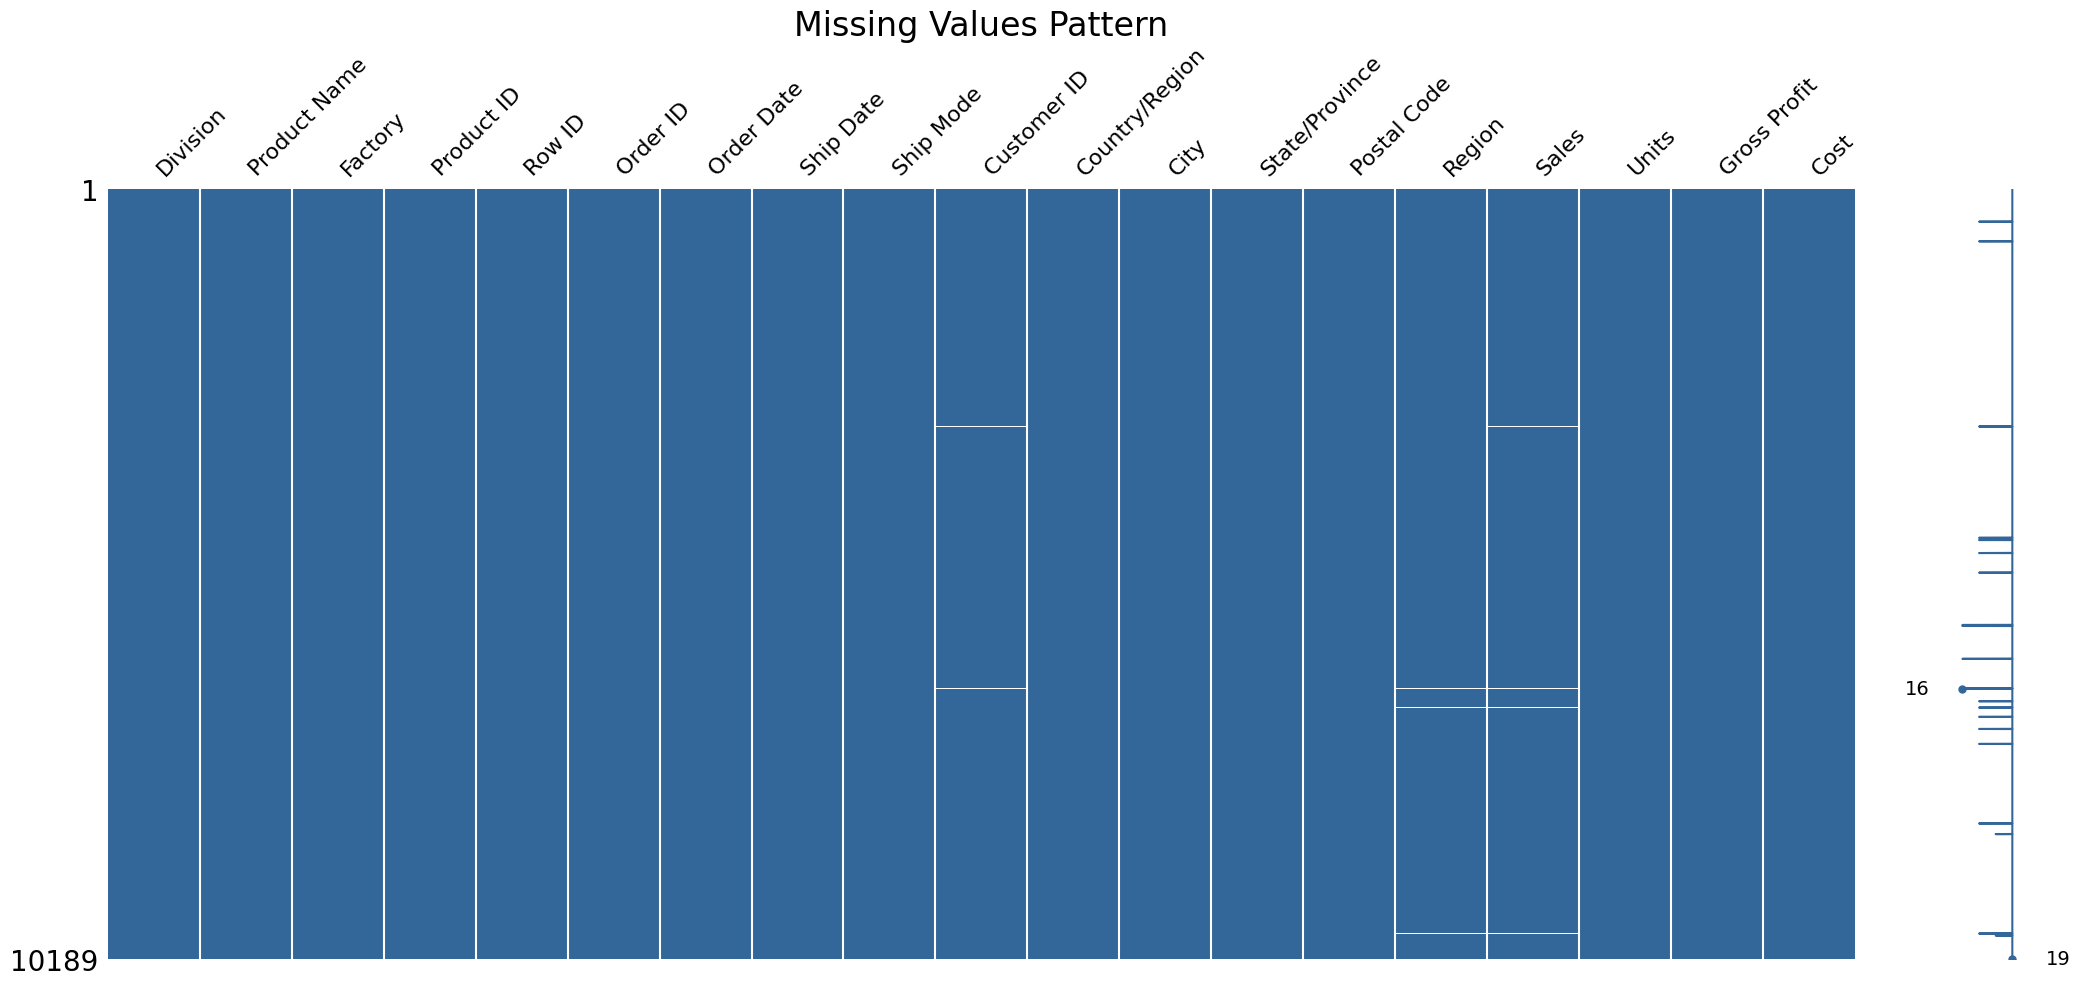

In [28]:
plt.figure(figsize=(8, 4))
msno.matrix(candy_df, color=(0.2, 0.4, 0.6)) 
plt.title('Missing Values Pattern', size=24)
plt.show()

#### - Handlying Missing Values

Since Customer ID , Region and Sales have very few missing values (<5% of the dataset), dropping rows is a safe and efficient strategy to maintain data integrity without significant loss.

In [30]:
candy_df = candy_df.dropna(subset=['Customer ID', 'Region', 'Sales'])

In [31]:
candy_df.isnull().sum()

Division          0
Product Name      0
Factory           0
Product ID        0
Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Country/Region    0
City              0
State/Province    0
Postal Code       0
Region            0
Sales             0
Units             0
Gross Profit      0
Cost              0
dtype: int64

#### - Drop Unwanted Features:

- Row ID: Arbitrary index (likely redundant with pandas' built-in index).
- Order ID:	Is actually a combination of Country + year ordered + CustomerID + ProductID. 
- Postal Code:	
- City: it might overlap with State/Province.


In [33]:
candy_df.drop(columns=['Row ID', 'Order ID', 'Postal Code', 'City'], inplace=True)

#### - Rename Columns and atibuites for readibility: 

In [35]:
candy_df = candy_df.rename(columns={
    'Division': 'Category',
    'Product Name': 'Product',
    'Product ID': 'ProductID',
    'Order Date': 'Ordered',
    'Ship Date': 'Shipped',
    'Ship Mode': 'Shipping',
    'Customer ID': 'CustomerID',
    'Country/Region': 'Country',
    'State/Province': 'State',
    'Units': 'Qty',
    'Gross Profit': 'Profit',
    'Cost': 'UnitCost'
})


In [36]:
## To remove all hyphens (-) from the Product column and replace them with spaces

candy_df['Product'] = candy_df['Product'].str.replace('-', ' ')

In [37]:
## Extracts only the numeric portion of Column ProductID

candy_df['ProductID'] = candy_df['ProductID'].str.extract(r'(\d+)')[0]

In [38]:
candy_df.head(5)

,Category,Product,Factory,ProductID,Ordered,Shipped,Shipping,CustomerID,Country,State,Region,Sales,Qty,Profit,UnitCost
0,Chocolate,Wonka Bar Nutty Crunch Surprise,Lot's O' Nuts,13000,19 08 2021,14 09 2021,Standard Class,115777.0,Canada,Quebec,Atlantic,3.49,1,2.49,1.0
1,Chocolate,Wonka Bar Nutty Crunch Surprise,Lot's O' Nuts,13000,2 12 2021,29 12 2021,Standard Class,117964.0,Canada,New Brunswick,Atlantic,24.43,7,17.43,7.0
2,Chocolate,Wonka Bar Nutty Crunch Surprise,Lot's O' Nuts,13000,4 12 2021,1 01 2022,Standard Class,119508.0,Canada,British Columbia,Pacific,20.94,6,14.94,6.0
3,Chocolate,Wonka Bar Nutty Crunch Surprise,Lot's O' Nuts,13000,24 09 2021,17 10 2021,Same Day,160325.0,Canada,Quebec,Atlantic,10.47,3,7.47,3.0
4,Chocolate,Wonka Bar Nutty Crunch Surprise,Lot's O' Nuts,13000,24 09 2021,17 10 2021,Same Day,160325.0,Canada,Quebec,Atlantic,6.98,2,4.98,2.0


#### - Check and drop Duplicate data

In [40]:
dup = candy_df.duplicated().sum()
print(f"Number of duplicated rows: {dup}")


Number of duplicated rows: 312


In [41]:
duplicated = candy_df[candy_df.duplicated(keep='first')]
duplicated.head(5)

,Category,Product,Factory,ProductID,Ordered,Shipped,Shipping,CustomerID,Country,State,Region,Sales,Qty,Profit,UnitCost
47,Chocolate,Wonka Bar Nutty Crunch Surprise,Lot's O' Nuts,13000,31 10 2021,27 11 2021,Standard Class,106439.0,United States,California,Pacific,10.47,3,7.47,3.0
54,Chocolate,Wonka Bar Nutty Crunch Surprise,Lot's O' Nuts,13000,2 10 2021,28 10 2021,First Class,108189.0,United States,Arizona,Pacific,6.98,2,4.98,2.0
62,Chocolate,Wonka Bar Nutty Crunch Surprise,Lot's O' Nuts,13000,29 12 2021,25 01 2022,Standard Class,110786.0,United States,California,Pacific,20.94,6,14.94,6.0
91,Chocolate,Wonka Bar Nutty Crunch Surprise,Lot's O' Nuts,13000,15 07 2021,9 08 2021,Standard Class,115980.0,United States,South Dakota,Interior,10.47,3,7.47,3.0
168,Chocolate,Wonka Bar Nutty Crunch Surprise,Lot's O' Nuts,13000,7 09 2021,5 10 2021,Second Class,131002.0,United States,Oklahoma,Interior,10.47,3,7.47,3.0


In [42]:
candy_df_drop = candy_df.drop_duplicates()
remaining_duplicates = candy_df_drop.duplicated().sum()
print(f"Duplicates remaining after drop: {remaining_duplicates}")


Duplicates remaining after drop: 0


#### - Convert Data Type

In [44]:
# Convert CustomerID float to int (removes .0 for non-null values) and then to string

candy_df['CustomerID'] = candy_df['CustomerID'].astype('Int64').astype(str)


In [45]:
candy_df['Ordered'] = pd.to_datetime(candy_df['Ordered'], dayfirst=True)
candy_df['Shipped'] = pd.to_datetime(candy_df['Shipped'], dayfirst=True)


In [46]:
print(f" start_date is from {candy_df['Ordered'].min()} - end_date is to {candy_df['Ordered'].max()}")

 start_date is from 2021-01-03 00:00:00 - end_date is to 2024-12-30 00:00:00


In [47]:
candy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10168 entries, 0 to 10188
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Category    10168 non-null  object        
 1   Product     10168 non-null  object        
 2   Factory     10168 non-null  object        
 3   ProductID   10168 non-null  object        
 4   Ordered     10168 non-null  datetime64[ns]
 5   Shipped     10168 non-null  datetime64[ns]
 6   Shipping    10168 non-null  object        
 7   CustomerID  10168 non-null  object        
 8   Country     10168 non-null  object        
 9   State       10168 non-null  object        
 10  Region      10168 non-null  object        
 11  Sales       10168 non-null  float64       
 12  Qty         10168 non-null  int64         
 13  Profit      10168 non-null  float64       
 14  UnitCost    10168 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(9)
memory usage: 1.2+ MB

#### - Feature engineering 

In [49]:
# Order Processing Time:

candy_df['Delivery_Time'] = (candy_df['Shipped'] - candy_df['Ordered']).dt.days

In [50]:
candy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10168 entries, 0 to 10188
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Category       10168 non-null  object        
 1   Product        10168 non-null  object        
 2   Factory        10168 non-null  object        
 3   ProductID      10168 non-null  object        
 4   Ordered        10168 non-null  datetime64[ns]
 5   Shipped        10168 non-null  datetime64[ns]
 6   Shipping       10168 non-null  object        
 7   CustomerID     10168 non-null  object        
 8   Country        10168 non-null  object        
 9   State          10168 non-null  object        
 10  Region         10168 non-null  object        
 11  Sales          10168 non-null  float64       
 12  Qty            10168 non-null  int64         
 13  Profit         10168 non-null  float64       
 14  UnitCost       10168 non-null  float64       
 15  Delivery_Time  10168 non

### - Check the Normality of the dataset 

Using Histogram with KDE and Q-Q Plot, along with Log Transformation to address skewness if needed:

#### - Numerical Features Distribuition:

In [53]:
Ncolumns = ['Sales', 'UnitCost', 'Profit', 'Qty', 'Delivery_Time']

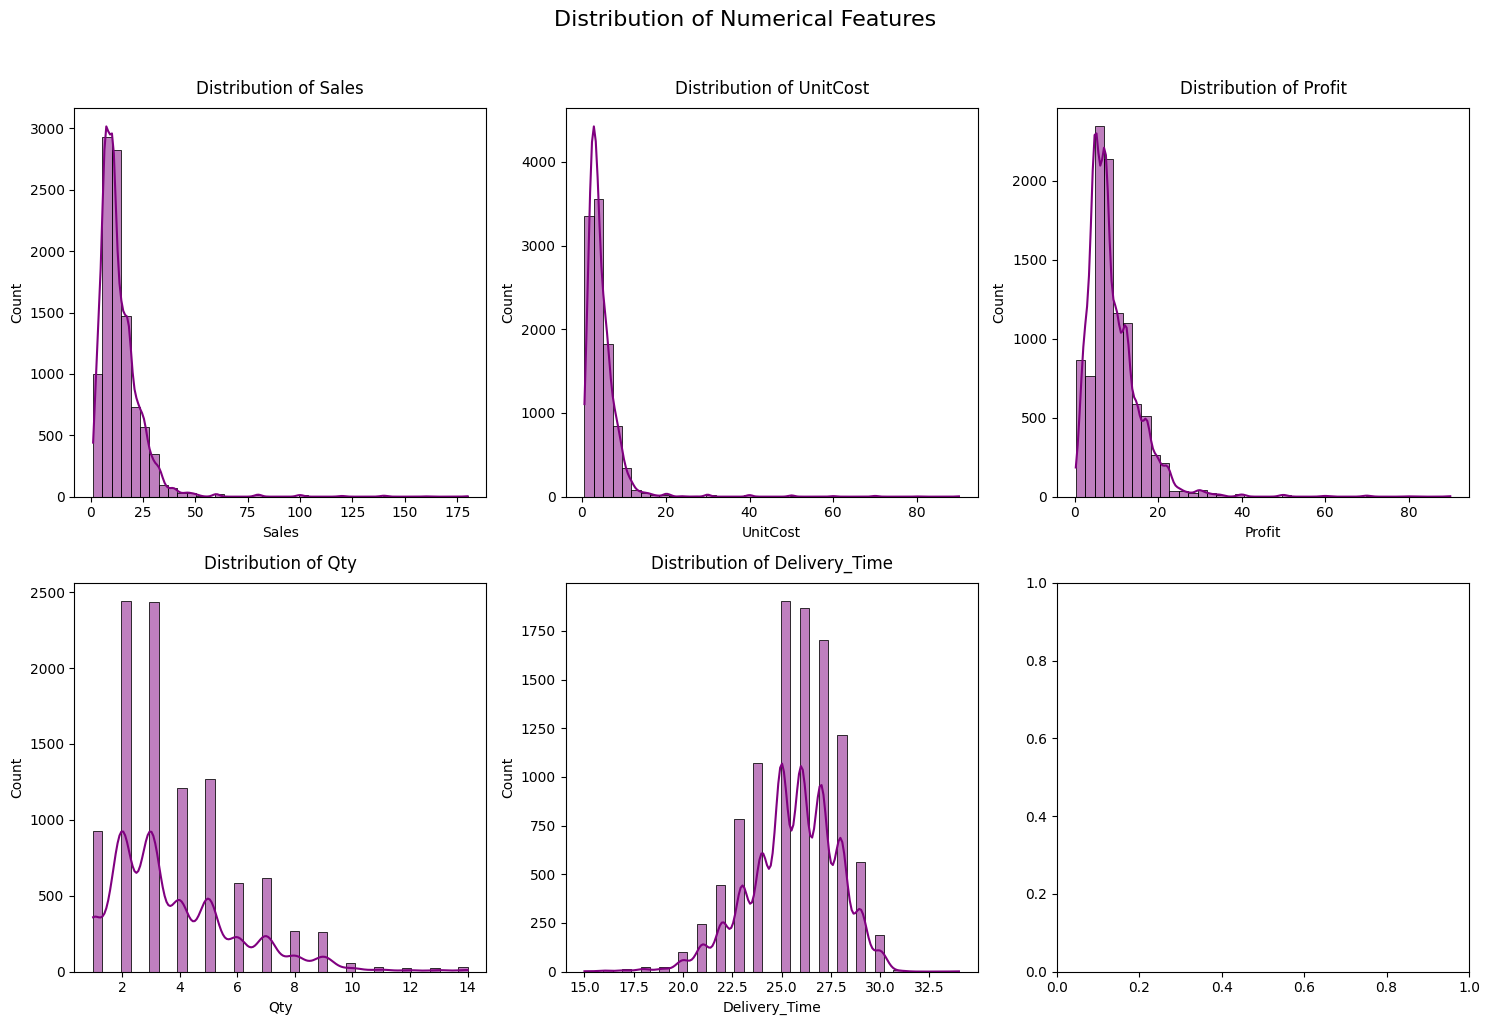

In [54]:
# Subplots with adjusted bin counts and proper title spacing
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Numerical Features', fontsize=16, y=1.02)  # y=1.02 adds vertical spacing

# Plot distributions with fewer bins
for i, col in enumerate(Ncolumns):
    sns.histplot(candy_df[col], 
                 kde=True, 
                 bins=40,
                 ax=axes[i//3, i%3], 
                 color='purple')
    axes[i//3, i%3].set_title(f'Distribution of {col}', pad=10)

# Adjust layout with additional top padding
plt.subplots_adjust(top=0.85)  # Creates space between suptitle and subplots (0.9 is default)
plt.tight_layout()
plt.show()

#### -Log Transformation to treat data Skew:

Log Transformation as the dataset contain is midle size (10K) and is right skewed. As we already see in the Data Visualization part, the Sales column having some outliers so it is important to handle this

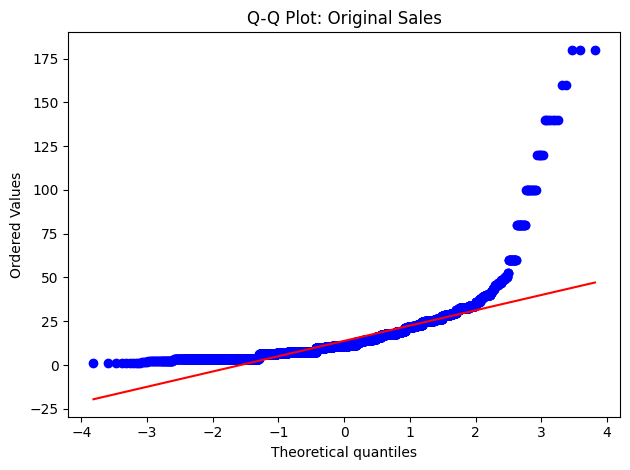

In [56]:
# Create figure with Q-Q plots

# Simple Q-Q plot in one line
stats.probplot(candy_df['Sales'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Original Sales')
plt.tight_layout()
plt.show()

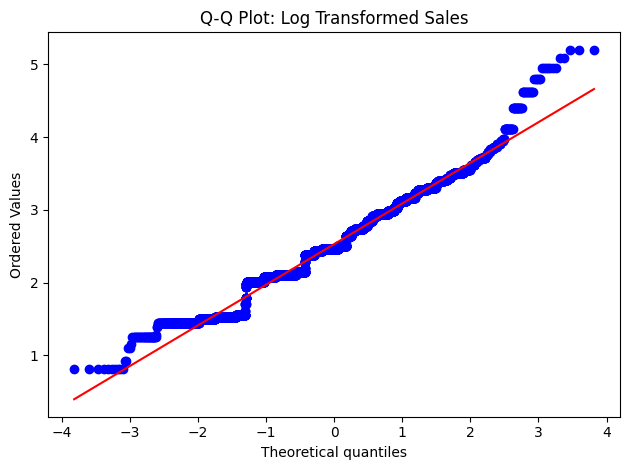

In [57]:
candy_df['Sales'] = np.log1p(candy_df['Sales'])

# Simple Q-Q plot in one line
stats.probplot(candy_df['Sales'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Log Transformed Sales')
plt.tight_layout()
plt.show()

## Descriptive analysis

#### - Check Unique Values for each variable

In [60]:
# number of unique values per column

unique = candy_df.nunique()

print("Number of unique values in each column:")
print(unique)

Number of unique values in each column:
Category            3
Product            15
Factory             5
ProductID          15
Ordered          1242
Shipped          1306
Shipping            4
CustomerID       5039
Country             2
State              59
Region              4
Sales              90
Qty                14
Profit            117
UnitCost           92
Delivery_Time      18
dtype: int64


##### Numerical Features:

In [62]:
candy_df[['Sales', 'UnitCost', 'Profit', 'Qty', 'Delivery_Time']].describe()

,Sales,UnitCost,Profit,Qty,Delivery_Time
count,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000
mean,2.528318,4.697264,9.116251,3.785700,25.609363
std,0.564735,4.603485,6.303796,2.214877,2.183037
min,0.810930,0.600000,0.250000,1.000000,15.000000
25%,2.104134,2.400000,4.900000,2.000000,24.000000
50%,2.468100,3.600000,7.470000,3.000000,26.000000
75%,2.944439,5.700000,12.250000,5.000000,27.000000
max,5.198497,90.000000,90.000000,14.000000,34.000000


##### Categorical Features:

In [64]:
candy_df.describe(include= object)

,Category,Product,Factory,ProductID,Shipping,CustomerID,Country,State,Region
count,10168,10168,10168,10168,10168,10168,10168,10168,10168
unique,3,15,5,15,4,5039,2,59,4
top,Chocolate,Wonka Bar Milk Chocolate,Lot's O' Nuts,31000,Standard Class,115238,United States,California,Pacific
freq,9824,2126,5685,2126,6105,24,9969,1997,3240


In [65]:
candy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10168 entries, 0 to 10188
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Category       10168 non-null  object        
 1   Product        10168 non-null  object        
 2   Factory        10168 non-null  object        
 3   ProductID      10168 non-null  object        
 4   Ordered        10168 non-null  datetime64[ns]
 5   Shipped        10168 non-null  datetime64[ns]
 6   Shipping       10168 non-null  object        
 7   CustomerID     10168 non-null  object        
 8   Country        10168 non-null  object        
 9   State          10168 non-null  object        
 10  Region         10168 non-null  object        
 11  Sales          10168 non-null  float64       
 12  Qty            10168 non-null  int64         
 13  Profit         10168 non-null  float64       
 14  UnitCost       10168 non-null  float64       
 15  Delivery_Time  10168 non

## Exploratory Data Analysis EDA

#### - Annual Sales 


In [68]:
candy_df['Year'] = candy_df['Ordered'].dt.year
annual_sales = candy_df.groupby('Year')['Sales'].sum().reset_index()
annual_sales

,Year,Sales
0,2021,5185.990822
1,2022,5363.978276
2,2023,6639.047224
3,2024,8518.921312


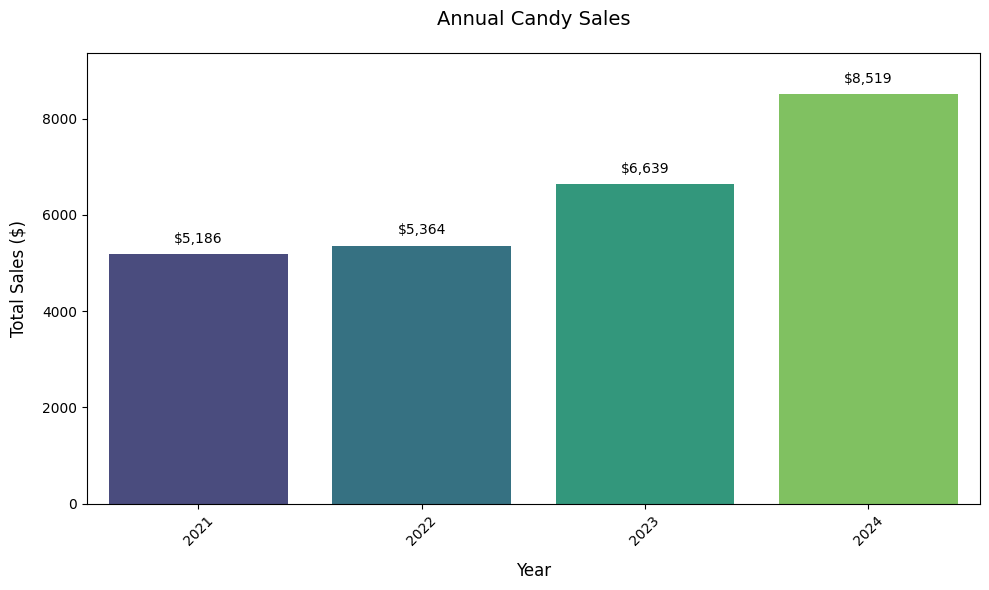

In [69]:
plt.figure(figsize=(10, 6))

# Create plot without grid lines
ax = sns.barplot(x='Year', y='Sales', data=annual_sales, palette='viridis')
ax.grid(False)  # Remove all grid lines

# Formatting
plt.title('Annual Candy Sales', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12, labelpad=10)
plt.ylabel('Total Sales ($)', fontsize=12, labelpad=10)
plt.xticks(rotation=45)

# Calculate safe label positions
max_sales = annual_sales['Sales'].max()
label_offset = 0.02 * max_sales  # Dynamic offset based on data

# Add perfectly positioned value labels
for index, row in annual_sales.iterrows():
    y_pos = min(row['Sales'] + label_offset, max_sales * 1.05)  # Prevent going off-chart
    ax.text(index, 
            y_pos, 
            f'${row["Sales"]:,.0f}', 
            ha='center', 
            va='bottom',
            fontsize=10)

# Set y-axis limit with buffer
plt.ylim(0, max_sales * 1.1)  # 10% buffer above highest bar



plt.tight_layout()
plt.show()

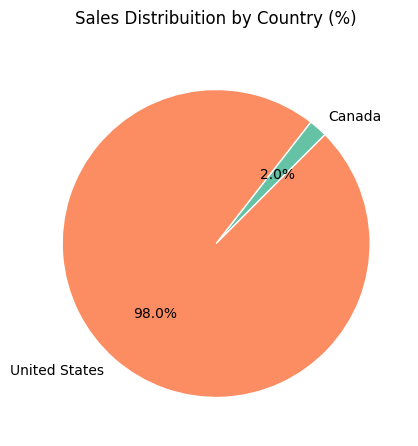

In [70]:
country_sales = candy_df.groupby('Country')['Sales'].sum()

plt.figure(figsize=(5, 5))
country_sales.plot.pie(
    colors=sns.color_palette('Set2'),
    autopct='%.1f%%',
    fontsize=10,
    wedgeprops={'edgecolor': 'white'},
    startangle=45,
)
plt.ylabel('')  # Remove default 'Sales' label
plt.title('Sales Distribuition by Country (%)', pad=20)
plt.show()

#### - Sales by State



In [72]:

state_sales = candy_df.groupby('State')['Sales'].sum().sort_values(ascending=False).head(5)
state_sales



State
California      5073.928815
New York        2829.596759
Texas           2472.823162
Pennsylvania    1463.189661
Washington      1260.510145
Name: Sales, dtype: float64

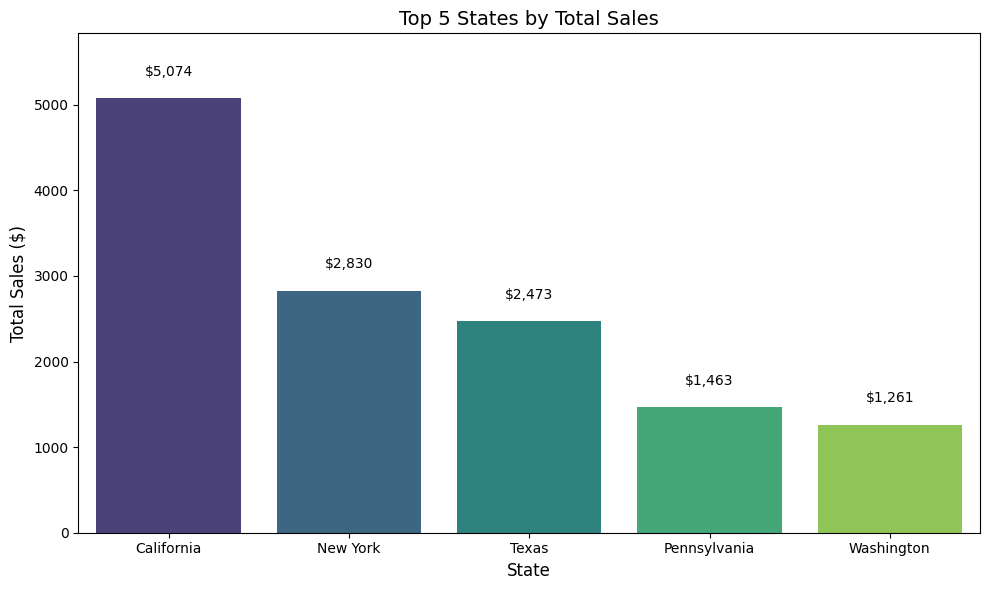

In [73]:

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=state_sales.index, y=state_sales.values, palette='viridis')
ax.grid(False)  # Remove all grid lines
plt.title('Top 5 States by Total Sales', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)

# Calculate dynamic padding (15% of max value)
y_padding = max(state_sales.values) * 0.15

# Set y-axis limit with padding
plt.ylim(0, max(state_sales.values) + y_padding)

# Add value labels - now positioned better
for i, value in enumerate(state_sales.values):
    ax.text(i,                          # x-position
            value + (y_padding * 0.3),  # y-position (30% of padding)
            f'${value:,.0f}',           # formatted value
            ha='center',                # horizontal alignment
            va='bottom',                # vertical alignment
            fontsize=10)

plt.tight_layout()
plt.show()

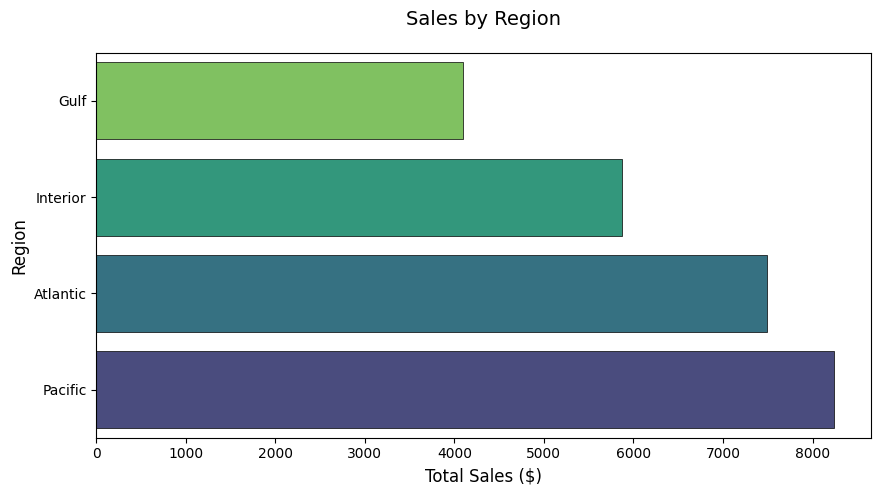

In [74]:
# By Region (if multiple regions exist)
if len(candy_df['Region'].unique()) > 1:
    plt.figure(figsize=(10, 5))
    region_sales = candy_df.groupby('Region')['Sales'].sum().sort_values()
    sns.barplot(x=region_sales.values,
                y=region_sales.index,
                palette='viridis_r',  # Try also: 'viridis', 'mako', 'flare'
                edgecolor='black',
                linewidth=0.5)
    plt.title('Sales by Region', fontsize=14, pad=20)
    plt.xlabel('Total Sales ($)', fontsize=12)
    plt.ylabel('Region', fontsize=12)
    plt.show()

In [75]:
#### - Sales vs Profit by Country

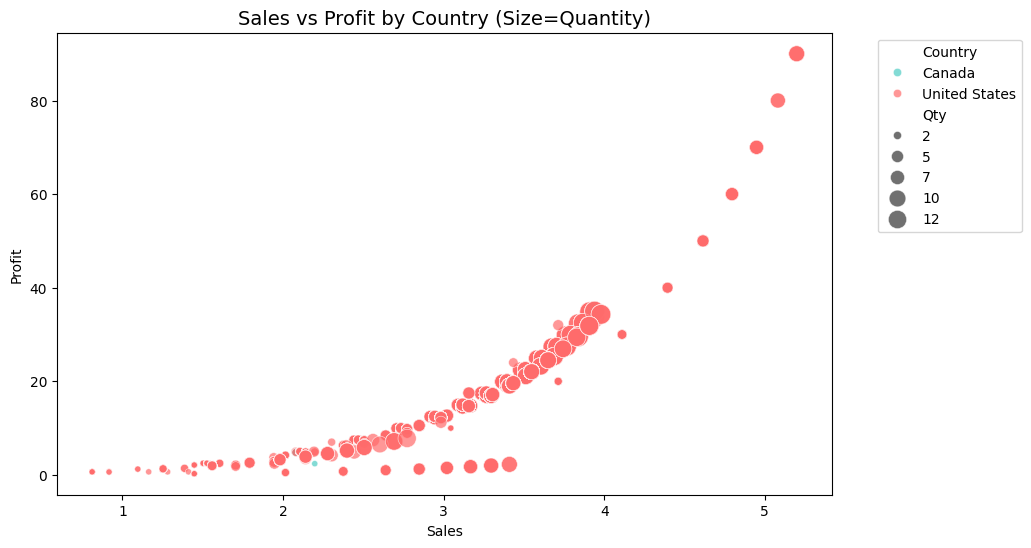

In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Profit', data=candy_df,
                hue='Country', palette=['#4ECDC4', '#FF6B6B'],
                alpha=0.7, size='Qty', sizes=(20, 200))
plt.title('Sales vs Profit by Country (Size=Quantity)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### - Low-Performing Products

In [78]:
low_sales = candy_df.groupby('Product')['Sales'].sum().sort_values().head(5)
low_sales

Product
Fun Dip                    4.566949
Nerds                      5.953243
Everlasting Gobstopper     7.147559
Hair Toffee               11.773586
Fizzy Lifting Drinks      15.679449
Name: Sales, dtype: float64

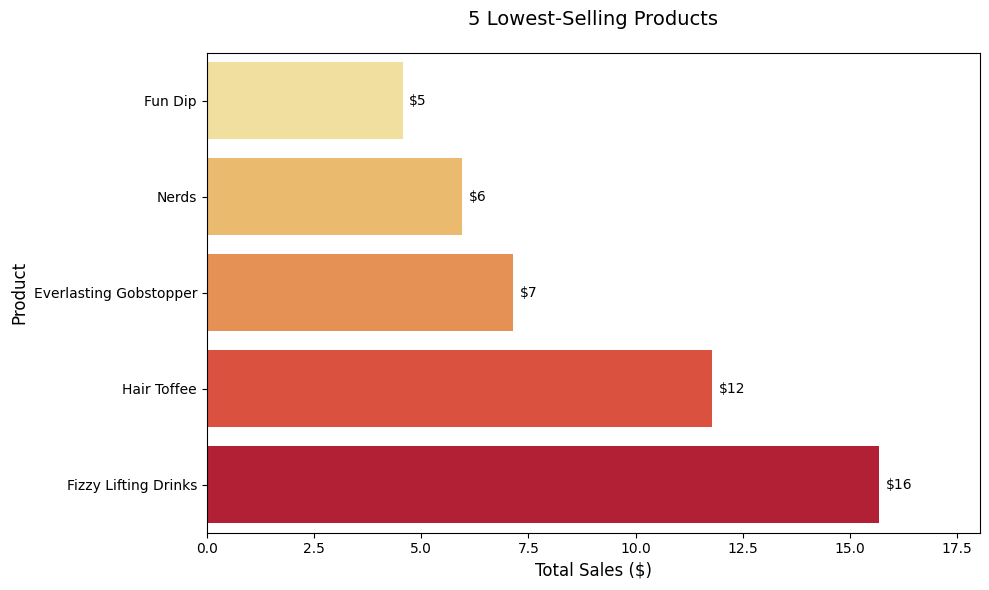

In [79]:
# Get bottom 5 products by sales
low_sales = candy_df.groupby('Product')['Sales'].sum().sort_values().head(5)

# Create figure
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=low_sales.values, y=low_sales.index, palette='YlOrRd', orient='h')


# Formatting
plt.title('5 Lowest-Selling Products', fontsize=14, pad=20)
plt.xlabel('Total Sales ($)', fontsize=12)
plt.ylabel('Product', fontsize=12)
plt.xlim(0, max(low_sales) * 1.15)  # Add 15% padding for labels

# Add value labels inside bars
for i, value in enumerate(low_sales):
    ax.text(value + (max(low_sales)*0.01),  # x-position (slightly right of bar)
            i,                             # y-position
            f'${value:,.0f}',              # formatted value
            va='center',                   # vertical alignment
            ha='left',                     # horizontal alignment
            fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.grid(False)
plt.tight_layout()

plt.show()

In [80]:
#### - Profit Margin by Product Category:

In [81]:
product_category = candy_df.groupby('Category')['Sales'].sum()
product_category

Category
Chocolate     24807.564275
Sugar            64.759490
Sugar Free      835.613869
Name: Sales, dtype: float64

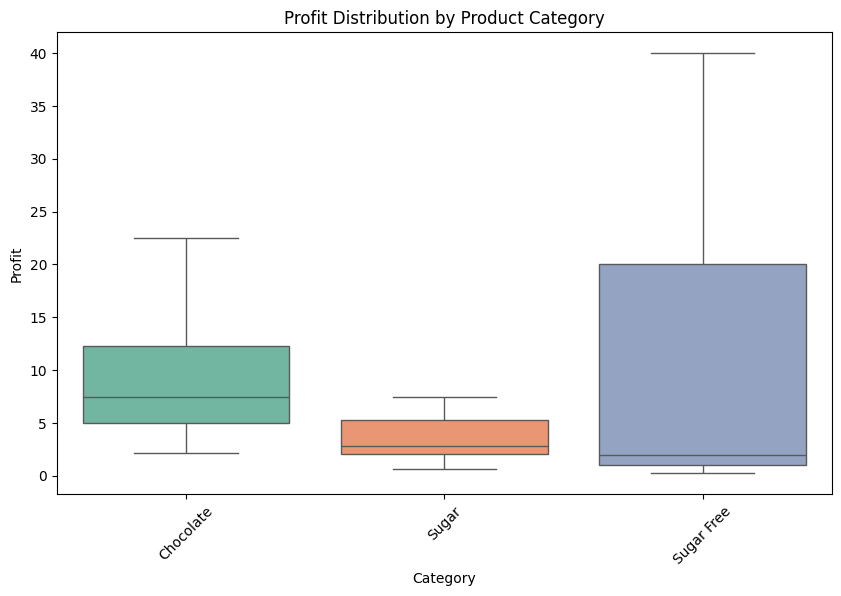

In [82]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Profit', data=candy_df, 
            palette='Set2', showfliers=False)
plt.title('Profit Distribution by Product Category')
plt.xticks(rotation=45)
plt.show()

#### - Shipping Analysis:

In [84]:
ship_mode = candy_df.groupby('Shipping')['Delivery_Time'].mean()
ship_mode

Shipping
First Class       23.817594
Same Day          21.708791
Second Class      24.839168
Standard Class    26.660606
Name: Delivery_Time, dtype: float64

In [85]:
candy_df['Delivery_Time'].describe()

count    10168.000000
mean        25.609363
std          2.183037
min         15.000000
25%         24.000000
50%         26.000000
75%         27.000000
max         34.000000
Name: Delivery_Time, dtype: float64

Text(0, 0.5, 'Days')

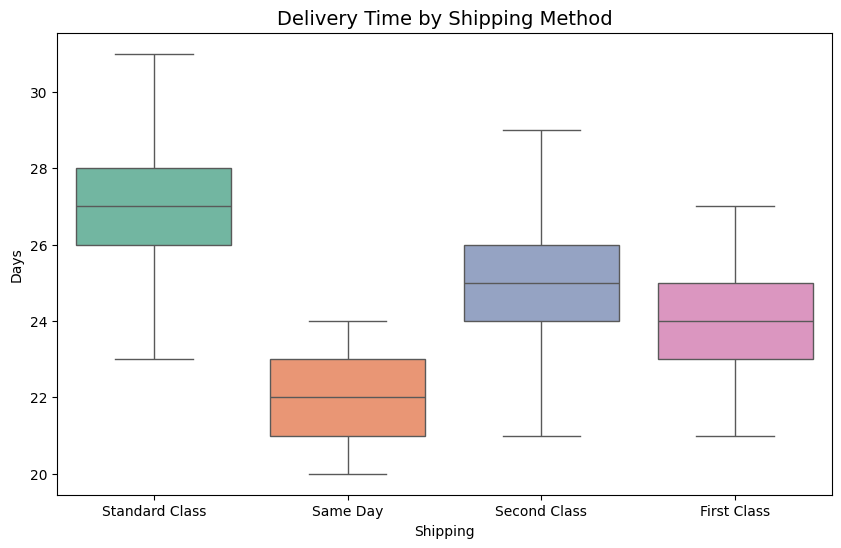

In [86]:
# Shipping Method Efficiency

plt.figure(figsize=(10, 6))
sns.boxplot(x='Shipping', y='Delivery_Time', data=candy_df, 
            palette='Set2', showfliers=False)
plt.title('Delivery Time by Shipping Method', fontsize=14)
plt.ylabel('Days')

#### - Customer Behavior - Customer Order Frequency

In [88]:
customer_orders = candy_df['CustomerID'].value_counts().head(10)

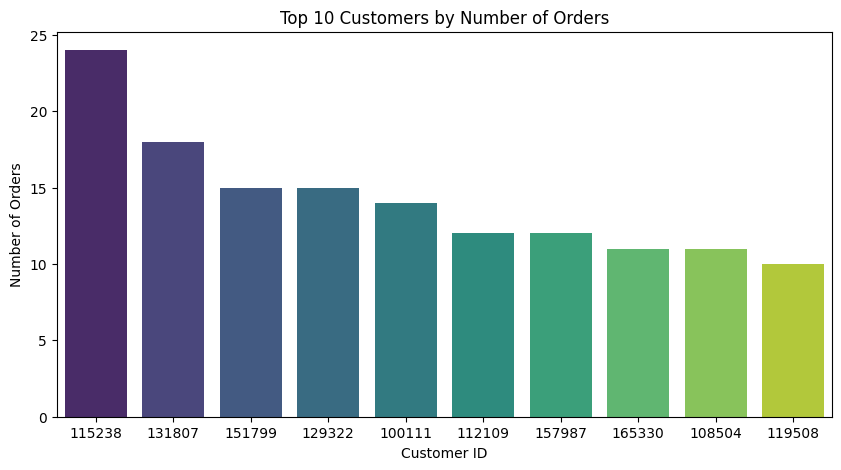

In [89]:
plt.figure(figsize=(10, 5))
sns.barplot(x=customer_orders.index, y=customer_orders.values, palette='viridis')
plt.title('Top 10 Customers by Number of Orders')
plt.xlabel('Customer ID')
plt.ylabel('Number of Orders')
plt.show()

In [90]:
#### Temporal Sales Analysis

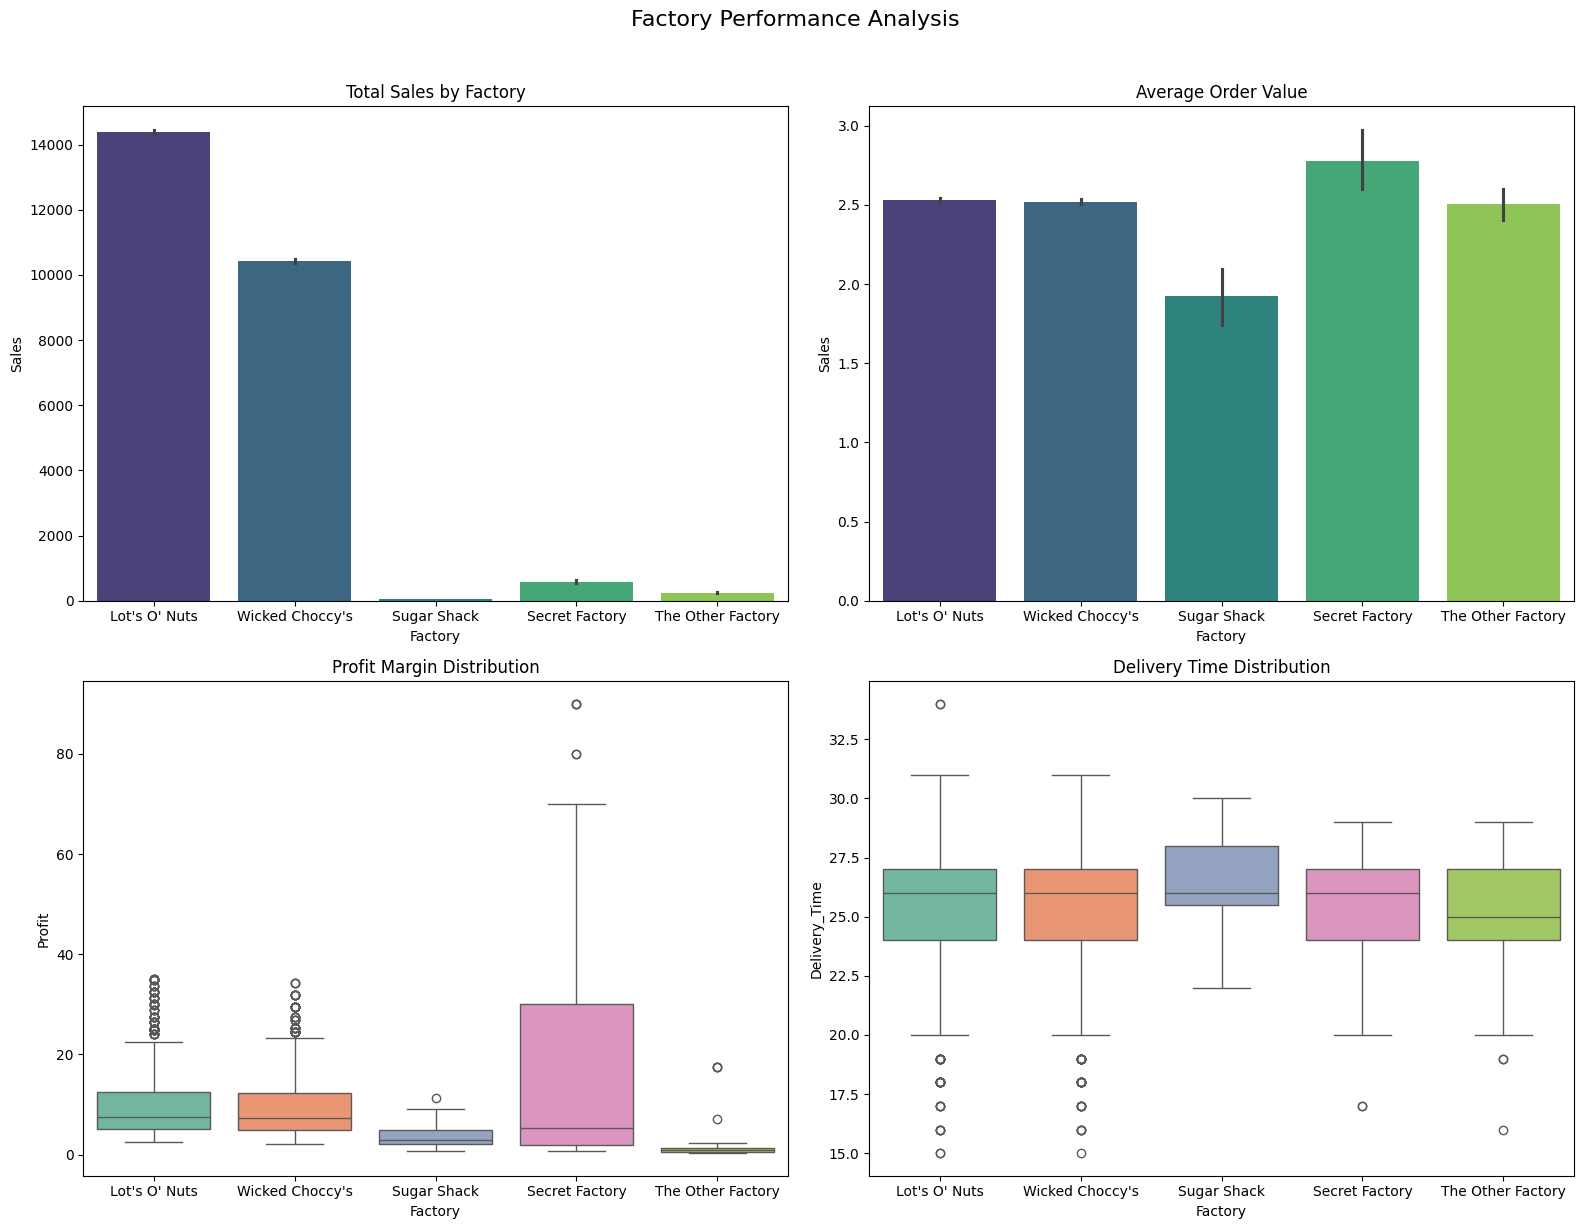

In [91]:
# Factory Comparison Dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Total Sales
sns.barplot(x='Factory', y='Sales', data=candy_df, 
            estimator=sum, ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Total Sales by Factory')

# Average Order Value
sns.barplot(x='Factory', y='Sales', data=candy_df, 
            estimator=np.mean, ax=axes[0,1], palette='viridis')
axes[0,1].set_title('Average Order Value')

# Profit Margins
sns.boxplot(x='Factory', y='Profit', data=candy_df, 
            ax=axes[1,0], palette='Set2')
axes[1,0].set_title('Profit Margin Distribution')

# Delivery Performance
sns.boxplot(x='Factory', y='Delivery_Time', data=candy_df, 
            ax=axes[1,1], palette='Set2')
axes[1,1].set_title('Delivery Time Distribution')

plt.suptitle('Factory Performance Analysis', fontsize=16, y=1.02)
plt.tight_layout()

- Observation:

The highest correlation is between the order year and shipping year followed by the order month and shipping month which may the signified that the delay rate of shipping is much less


### - Conclusion from the Data Visualization:

We can say that more profitable region is West and East whereas New york and California having highest profitable states.
and in terms of the Product Category Technology is highest but Furniture and Office Supplier are also good there are so many demand in all these product category
And in terms of the month the 9,11,12 are most preferable month maybe due to festive season or holidays

## Hypothesis 


Hypothesis: Delivery Time Affects Profit Margin
Null Hypothesis (H₀): There is no relationship between delivery time and profit percentage (i.e., the mean profit% is the same regardless of delivery time).

Alternative Hypothesis (H₁): Longer delivery times are associated with lower profit percentages (i.e., there is a negative correlation between delivery time and profit%).

Rationale:

Businesses often face a trade-off between speed of delivery and profitability

Faster deliveries might require more expensive shipping methods that cut into profits

Alternatively, longer deliveries might lead to customer dissatisfaction and thus require discounts

This could be particularly interesting if you segment by shipping method or region

Potential Test Approach:

Calculate correlation between Delivery_Time and Profit%

Perform a t-test comparing profit% between:

Fast deliveries (bottom quartile of Delivery_Time)

Slow deliveries (top quartile of Delivery_Time)

Alternatively, you could do an ANOVA test across multiple delivery time brackets

Additional Interesting Angles:

Does this relationship hold across all Categories or are some product categories more sensitive to delivery times?

Is the effect more pronounced in certain Regions?

Does the relationship change if you control for Shipping method?

Why This is Interesting:
This could provide actionable insights about whether the company should invest in faster delivery systems, or whether certain delivery time thresholds significantly impact profitability. The results could inform logistics strategy and pricing models.

#### - H1: "Shipping Mode Impacts Profitability More Than Sales Volume"

- Question: Does choosing a faster shipping method (e.g., "Express") significantly increase gross profit, even if sales volume remains stable?
Why It’s Interesting:

- Faster shipping might reduce cart abandonment or attract premium customers, boosting profit margins despite higher costs.

- Test: Compare average Gross Profit and Cost across Ship Mode categories. Use ANOVA or regression with Ship Mode as a predictor.
- Potential Insight: Optimizing shipping strategies could maximize profitability, not just revenue.

H₀ (Null Hypothesis): Shipping mode has no significant impact on profitability (%)

H₁ (Alternative Hypothesis): Shipping mode significantly impacts profitability (%)

Two-Sample T-Test (Fast vs. Slow Deliveries)
If we want to compare fast vs. slow deliveries, we can split the data into two groups and conduct an independent t-test.

H₀: Mean Profit% is the same for fast and slow deliveries.
H₁: Mean Profit% is lower for slow deliveries.

Shipping Methods: ['Standard Class' 'Same Day' 'Second Class' 'First Class']


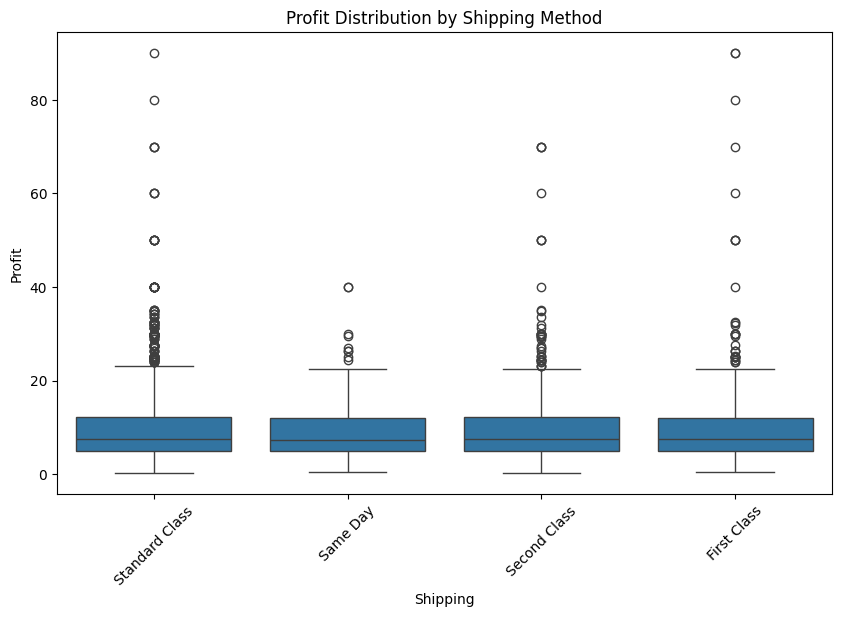

Levene's Test for equal variances:
LeveneResult(statistic=0.5205952246699365, pvalue=0.6680952150952126)

One-way ANOVA Results:
F-value: 1.5003254900393581
p-value: 0.21227231291735046

Fail to reject H₀ (p = 0.2123). No significant difference in profits between shipping methods.


In [99]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming candy_df is already loaded
# Let's first explore the shipping methods and their profits

# Check unique shipping methods
print("Shipping Methods:", candy_df['Shipping'].unique())

# Visualize the data
plt.figure(figsize=(10, 6))
sns.boxplot(x='Shipping', y='Profit', data=candy_df)
plt.title('Profit Distribution by Shipping Method')
plt.xticks(rotation=45)
plt.show()

# Since we're comparing more than 2 groups, we'll use ANOVA
# First check assumptions:
# 1. Normality (we'll assume given the sample size)
# 2. Homogeneity of variances

# Check variances
groups = [group['Profit'] for name, group in candy_df.groupby('Shipping')]
print("Levene's Test for equal variances:")
print(stats.levene(*groups))

# If p-value > 0.05, we can proceed with ANOVA
print("\nOne-way ANOVA Results:")
f_val, p_val = stats.f_oneway(*groups)
print("F-value:", f_val)
print("p-value:", p_val)

# Interpretation
alpha = 0.05
if p_val < alpha:
    print(f"\nReject H₀ (p = {p_val:.4f}). There is significant difference in profits between shipping methods.")
    # If significant, perform post-hoc test to see which groups differ
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey = pairwise_tukeyhsd(candy_df['Profit'], candy_df['Shipping'], alpha=alpha)
    print("\nPost-hoc Tukey HSD Test:")
    print(tukey.summary())
else:
    print(f"\nFail to reject H₀ (p = {p_val:.4f}). No significant difference in profits between shipping methods.")

#### H2 
- H₀: Products with higher unit costs have the same profit percentage as cheaper products
- H₁: Products with higher unit costs have significantly different profit percentages   

Normality p-values: High-cost=0.000, Low-cost=0.000
Equal variance p-value (Levene’s test): 0.000

Test used: Mann-Whitney U test
P-value: 0.0000
Conclusion: Reject H₀ (Profit% differs significantly between high and low-cost products)


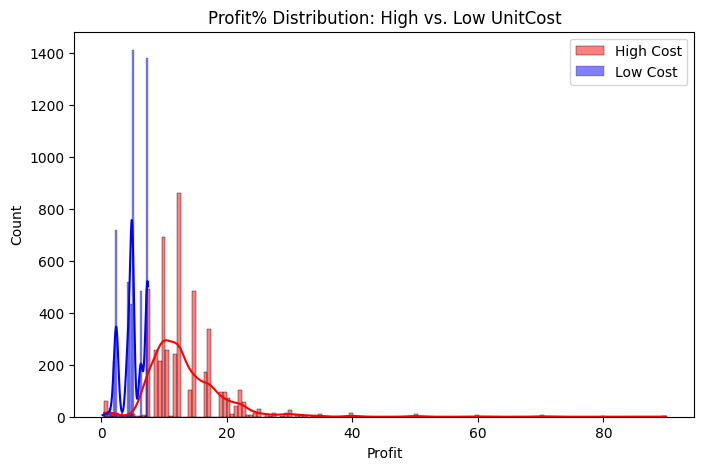

In [102]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (if not already loaded)
# candy_df = pd.read_csv('your_data.csv')

# Step 1: Split data into high-cost and low-cost groups
median_cost = candy_df['UnitCost'].median()
high_cost = candy_df[candy_df['UnitCost'] > median_cost]['Profit']
low_cost = candy_df[candy_df['UnitCost'] <= median_cost]['Profit']

# Step 2: Check normality (Shapiro-Wilk test)
_, p_high = stats.shapiro(high_cost)
_, p_low = stats.shapiro(low_cost)
print(f"Normality p-values: High-cost={p_high:.3f}, Low-cost={p_low:.3f}")

# Step 3: Check equal variance (Levene’s test)
_, p_levene = stats.levene(high_cost, low_cost)
print(f"Equal variance p-value (Levene’s test): {p_levene:.3f}")

# Step 4: Perform the appropriate test
if p_high > 0.05 and p_low > 0.05 and p_levene > 0.05:
    # Parametric t-test (if normality and equal variance hold)
    t_stat, p_value = stats.ttest_ind(high_cost, low_cost, equal_var=True)
    test_used = "Independent t-test"
else:
    # Non-parametric Mann-Whitney U test
    u_stat, p_value = stats.mannwhitneyu(high_cost, low_cost, alternative='two-sided')
    test_used = "Mann-Whitney U test"

# Step 5: Interpret results
print(f"\nTest used: {test_used}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: Reject H₀ (Profit% differs significantly between high and low-cost products)")
else:
    print("Conclusion: Fail to reject H₀ (No significant difference in Profit)")

# Optional: Visualize distributions
plt.figure(figsize=(8, 5))
sns.histplot(high_cost, color='red', label='High Cost', kde=True, alpha=0.5)
sns.histplot(low_cost, color='blue', label='Low Cost', kde=True, alpha=0.5)
plt.title("Profit% Distribution: High vs. Low UnitCost")
plt.xlabel("Profit")
plt.legend()
plt.show()

This indicates that products with higher unit costs have a statistically different Profit% compared to cheaper products.

## Time Series analysis

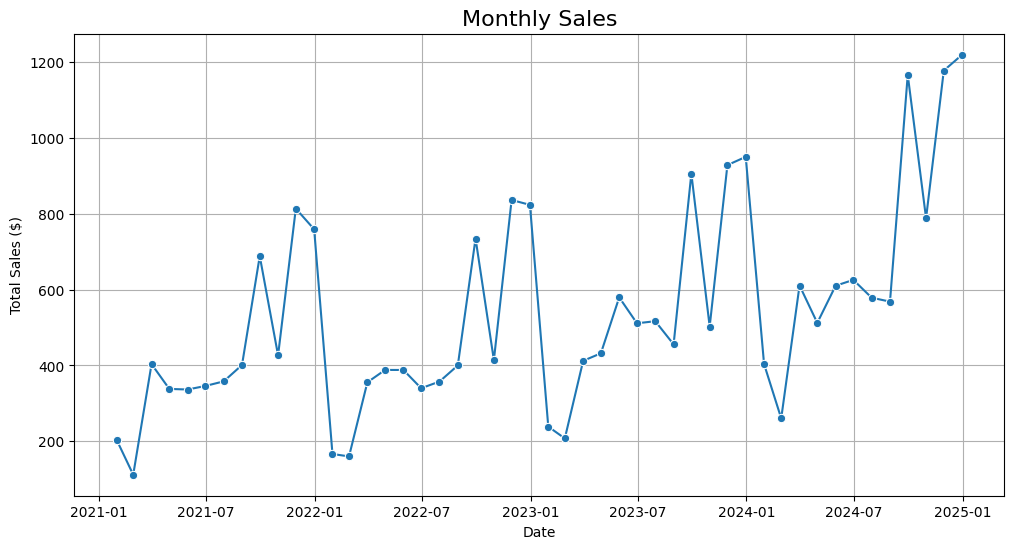

In [105]:
# Resample by month
monthly_sales = candy_df.resample('M', on='Ordered')['Sales'].sum()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, marker='o')
plt.title("Monthly Sales", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Sales ($)")
plt.grid(True)

In [106]:
regions = candy_df['Region'].unique()
shipModes = candy_df['Shipping'].unique()
categories = candy_df['Category'].unique()

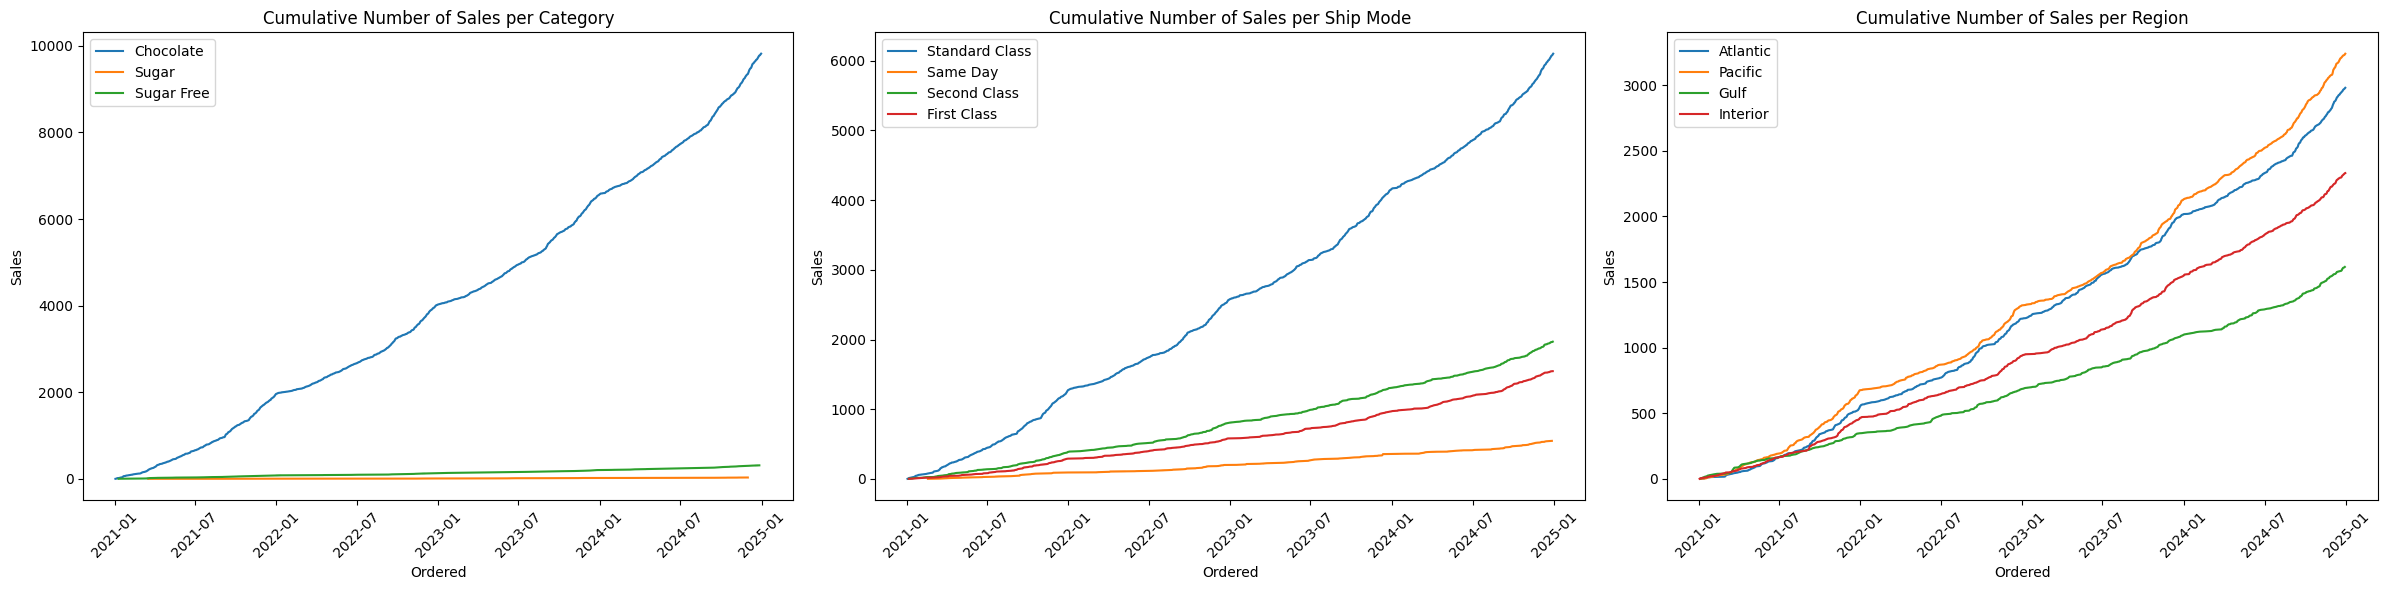

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)  # Increased spacing between subplots

# Get unique categories for legend
categories = candy_df['Category'].unique()
shipModes = candy_df['Shipping'].unique()
regions = candy_df['Region'].unique()

# 1. Cumulative Sales by Category
plt.subplot(1, 3, 1)
plt.title('Cumulative Number of Sales per Category')
for cat in categories:
    # Filter data for this category and sort by date
    cat_data = candy_df[candy_df['Category'] == cat].sort_values('Ordered')
    # Calculate cumulative sum of sales counts
    cumulative_sales = cat_data['Sales'].expanding().count()
    # Plot with date on x-axis
    sns.lineplot(x=cat_data['Ordered'], y=cumulative_sales, label=cat)
plt.xticks(rotation=45)
plt.legend()

# 2. Cumulative Sales by Shipping Mode
plt.subplot(1, 3, 2)
plt.title('Cumulative Number of Sales per Ship Mode')
for shipMode in shipModes:
    ship_data = candy_df[candy_df['Shipping'] == shipMode].sort_values('Ordered')
    cumulative_sales = ship_data['Sales'].expanding().count()
    sns.lineplot(x=ship_data['Ordered'], y=cumulative_sales, label=shipMode)
plt.xticks(rotation=45)
plt.legend()

# 3. Cumulative Sales by Region
plt.subplot(1, 3, 3)
plt.title('Cumulative Number of Sales per Region')
for region in regions:
    region_data = candy_df[candy_df['Region'] == region].sort_values('Ordered')
    cumulative_sales = region_data['Sales'].expanding().count()
    sns.lineplot(x=region_data['Ordered'], y=cumulative_sales, label=region)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### - Drop Unwanted Features again (Preparing for ML):

- ProductID = Unique identifier (no predictive value)
- CustomerID = Unique identifier (unless customer behavior matters)
- Year = Redundant with ordered (or can be feature-engineered)
- Shipped = Redundant with Ordered + Delivery_Time
- Product = Too many unique values (unless aggregated)
- Profit = Data leakage - Profit is typically calculated from Sales



In [109]:
candy_df.drop(columns=[ 'Shipped', 'Profit', 'Product', 'Year', 'ProductID', 'CustomerID','State'], inplace=True)


#### - Categorical Features (Need Encoding)

- Category = Product type matters 
- Factory = Manufacturing location may affect sales
- Shipping = Shipping method (e.g., express vs. standard)
- Country, State, Region = Geographic trends

In [111]:
candy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10168 entries, 0 to 10188
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Category       10168 non-null  object        
 1   Factory        10168 non-null  object        
 2   Ordered        10168 non-null  datetime64[ns]
 3   Shipping       10168 non-null  object        
 4   Country        10168 non-null  object        
 5   Region         10168 non-null  object        
 6   Sales          10168 non-null  float64       
 7   Qty            10168 non-null  int64         
 8   UnitCost       10168 non-null  float64       
 9   Delivery_Time  10168 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 873.8+ KB


In [112]:
candy_df.nunique()

Category            3
Factory             5
Ordered          1242
Shipping            4
Country             2
Region              4
Sales              90
Qty                14
UnitCost           92
Delivery_Time      18
dtype: int64

## Data Encoding
Before going to train the model we need to convert object data into appropiated numeric values by using some of the Data encoding techniques
- Key Considerations
Avoid Leakage: Ensure Gross Profit/Cost aren’t used to predict Sales (if they’re derived from it).

Dimensionality: High-cardinality features (City, State) may require feature hashing or embeddings.

- Category (Product Category) One-Hot Encoding as Categories are nominal (no ordinal relationship). Few enough to avoid dimensionality explosion.
- Factory (Manufacturing Location) One-Hot Encoding as Categories are nominal (no ordinal relationship). Few enough to avoid dimensionality explosion.
- Shipping (Shipping Method) One-Hot Encoding if no ordinal relationship.
- Country Only 2 countries (e.g., "USA" and "Canada") Binary encoding reduces to a single column (0/1)
- Region (4 unique values) Low cardinality (4 regions) No clear ordinal relationship
- Ordered (Datetime) Feature Engineering (Not Encoding): Extract useful temporal features instead of dropping:

In [114]:
# - Category (Product Category) One-Hot Encoding as Categories are nominal (no ordinal relationship). Few enough to avoid dimensionality explosion.
candy_df = pd.get_dummies(candy_df, columns=['Category'], prefix='Category')

In [115]:
# Factory (Manufacturing Location) One-Hot Encoding as Categories are nominal (no ordinal relationship). Few enough to avoid dimensionality explosion
candy_df = pd.get_dummies(candy_df, columns=['Factory'], prefix='Factory')

In [116]:
#- Shipping (Shipping Method) One-Hot Encoding if no ordinal relationship.
candy_df = pd.get_dummies(candy_df, columns=['Shipping'], prefix='Ship')

In [117]:
#- Only 2 countries (e.g., "USA" and "Canada") Binary encoding reduces to a single column (0/1)
candy_df = pd.get_dummies(candy_df, columns=['Country'], prefix='Country')

In [118]:
# Region (4 unique values) Low cardinality (4 regions) No clear ordinal relationship

candy_df = pd.get_dummies(candy_df, columns=['Region'], prefix='Region')

In [119]:
# - Ordered (Datetime) Feature Engineering (Not Encoding): Extract useful temporal features instead of dropping:

candy_df['Order_Year'] = candy_df['Ordered'].dt.year
candy_df['Order_Month'] = candy_df['Ordered'].dt.month  # Seasonality
candy_df['Order_DayOfWeek'] = candy_df['Ordered'].dt.dayofweek  # Weekend effect
candy_df.drop('Ordered', axis=1, inplace=True)

## Final Preprocessed DataFrame Structure
Numeric Features	Encoded Categorical Features
Qty	Category_Furniture (OHE)
UnitCost	Category_Electronics (OHE)
Delivery_Time	Factory_Encoded (Target)
Order_Year	Shipping_Encoded (Ordinal)
Order_Month	Country_Encoded (Binary)
Order_DayOfWeek	Region_North (OHE)
Key Takeaways
Low-Cardinality (≤5): One-Hot Encoding (Category, Region)

Moderate-Cardinality (5-10): Target Encoding (Factory)

Ordinal Data: Ordinal Encoding (Shipping)

Binary Data: Binary Encoding (Country)

Datetime: Feature extraction (Year/Month/DayOfWeek)

Why Not Label Encoding?
Label encoding (0,1,2,...) is unsafe for non-ordinal data (e.g., Category), as it artificially introduces numeric relationships where none exist.

In [121]:
candy_df

,Sales,Qty,UnitCost,Delivery_Time,Category_Chocolate,Category_Sugar,Category_Sugar Free,Factory_Lot's O' Nuts,Factory_Secret Factory,Factory_Sugar Shack,Factory_The Other Factory,Factory_Wicked Choccy's,Ship_First Class,Ship_Same Day,Ship_Second Class,Ship_Standard Class,Country_Canada,Country_United States,Region_Atlantic,Region_Gulf,Region_Interior,Region_Pacific,Order_Year,Order_Month,Order_DayOfWeek
0,1.501853,1,1.0,26,True,False,False,True,False,False,False,False,False,False,False,True,True,False,True,False,False,False,2021,8,3
1,3.235930,7,7.0,27,True,False,False,True,False,False,False,False,False,False,False,True,True,False,True,False,False,False,2021,12,3
2,3.088311,6,6.0,28,True,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,True,2021,12,5
3,2.439735,3,3.0,23,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,2021,9,4
4,2.076938,2,2.0,23,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,2021,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10184,2.639057,4,12.0,25,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,2024,10,6
10185,2.639057,4,12.0,26,False,False,True,False,False,False,True,False,False,False,True,False,False,True,True,False,False,False,2024,4,1
10186,2.639057,4,12.0,23,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,2024,11,2
10187,2.374906,3,9.0,25,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,2024,11,5


## Data Spliting x_train and y_train
Split the data into two parts for training and testing purpose

In [123]:
# Separate features (X) and target (y)

X = candy_df.drop("Sales", axis=1)  # All columns except "Sales"
y = candy_df["Sales"]               # Only the "Sales" column

In [124]:
# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###  - Scaling the Features 
(important for KNN, Ridge, Lasso). Decision Trees and Random Forest don’t require scaling.

In [126]:
# Transforming data
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
     

## Implementing Supervised Machine Learning algorithms.

#### 1 - Linear Regression: 
Linear Regression assumes a linear relationship between the input features and the target. It doesn’t require hyperparameter tuning.

In [143]:
# Fitting Multiple Linear Regression to the Training set
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

# 1. Create and train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# 2. Make predictions
lr_train_pred = lr.predict(X_train)
lr_test_pred = lr.predict(X_test)

# 3. Calculate performance scores
lr_train_score = lr.score(X_train, y_train)
lr_test_score = lr.score(X_test, y_test)

# 6. Evaluate the model
lr_metrics = {
    'Model': 'Linear Regression',
    'Train RMSE': sqrt(mean_squared_error(y_train, lr_train_pred)),
    'Test RMSE': sqrt(mean_squared_error(y_test, lr_test_pred)),
    'Train R2': r2_score(y_train, lr_train_pred),
    'Test R2': r2_score(y_test, lr_test_pred)
}




Linear Regression Performance:
Training R²: 0.8767
Testing R²: 0.8776
Training RMSE: 0.1980
Testing RMSE: 0.1986


In [171]:
print("\nLinear Regression Performance:")
print(f"Training R²: {lr_train_score:.4f}")
print(f"Testing R²: {lr_test_score:.4f}")
print(f"Training RMSE: {lr_metrics['Train RMSE']:.4f}")
print(f"Testing RMSE: {lr_metrics['Test RMSE']:.4f}")


Linear Regression Performance:
Training R²: 0.8767
Testing R²: 0.8776
Training RMSE: 0.1980
Testing RMSE: 0.1986


In [149]:
from sklearn.ensemble import RandomForestRegressor

# 1. Hyperparameter grid
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 2. Set up GridSearchCV
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=rf_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# 3. Fit the model
rf_grid.fit(X_train, y_train)

# 4. Get best model
best_rf = rf_grid.best_estimator_

# 5. Make predictions
rf_train_pred = best_rf.predict(X_train)
rf_test_pred = best_rf.predict(X_test)

# 6. Evaluate the model
rf_metrics = {
    'Model': 'Random Forest',
    'Train RMSE': sqrt(mean_squared_error(y_train, rf_train_pred)),
    'Test RMSE': sqrt(mean_squared_error(y_test, rf_test_pred)),
    'Train R²': r2_score(y_train, rf_train_pred),
    'Test R²': r2_score(y_test, rf_test_pred),
    'Best Params': rf_grid.best_params_
}



Random Forest Results:
Training R²: 0.9996
Testing R²: 0.9991
Training RMSE: 0.0107
Testing RMSE: 0.0166
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [169]:

# Print Random Forest results
print("\nRandom Forest Results:")
print(f"Training R²: {rf_metrics['Train R²']:.4f}")
print(f"Testing R²: {rf_metrics['Test R²']:.4f}")
print(f"Training RMSE: {rf_metrics['Train RMSE']:.4f}")
print(f"Testing RMSE: {rf_metrics['Test RMSE']:.4f}")
print(f"Best Parameters: {rf_metrics['Best Params']}")


Random Forest Results:
Training R²: 0.9996
Testing R²: 0.9991
Training RMSE: 0.0107
Testing RMSE: 0.0166
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [157]:
#!pip install xgboost

In [154]:
from xgboost import XGBRegressor

# 1. Hyperparameter grid
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 2. Set up GridSearchCV
xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid=xgb_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# 3. Fit the model
xgb_grid.fit(X_train, y_train)

# 4. Get best model
best_xgb = xgb_grid.best_estimator_

# 5. Make predictions
xgb_train_pred = best_xgb.predict(X_train)
xgb_test_pred = best_xgb.predict(X_test)

# 6. Evaluate the model
xgb_metrics = {
    'Model': 'XGBoost',
    'Train RMSE': sqrt(mean_squared_error(y_train, xgb_train_pred)),
    'Test RMSE': sqrt(mean_squared_error(y_test, xgb_test_pred)),
    'Train R²': r2_score(y_train, xgb_train_pred),
    'Test R²': r2_score(y_test, xgb_test_pred),
    'Best Params': xgb_grid.best_params_
}

In [167]:
# Print XGBoost results
print("\nXGBoost Results:")
print(f"Training R²: {xgb_metrics['Train R²']:.4f}")
print(f"Testing R²: {xgb_metrics['Test R²']:.4f}")
print(f"Training RMSE: {xgb_metrics['Train RMSE']:.4f}")
print(f"Testing RMSE: {xgb_metrics['Test RMSE']:.4f}")
print(f"Best Parameters: {xgb_metrics['Best Params']}")


XGBoost Results:
Training R²: 1.0000
Testing R²: 0.9986
Training RMSE: 0.0006
Testing RMSE: 0.0209
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}


In [159]:
from sklearn.svm import SVR

# 1. Hyperparameter grid
svr_params = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1],
    'kernel': ['linear', 'rbf']
}

# 2. Set up GridSearchCV
svr_grid = GridSearchCV(
    SVR(),
    param_grid=svr_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# 3. Fit the model
svr_grid.fit(X_train_scaled, y_train)

# 4. Get best model
best_svr = svr_grid.best_estimator_

# 5. Make predictions
svr_train_pred = best_svr.predict(X_train_scaled)
svr_test_pred = best_svr.predict(X_test_scaled)

# 6. Evaluate the model
svr_metrics = {
    'Model': 'SVR',
    'Train RMSE': sqrt(mean_squared_error(y_train, svr_train_pred)),
    'Test RMSE': sqrt(mean_squared_error(y_test, svr_test_pred)),
    'Train R²': r2_score(y_train, svr_train_pred),
    'Test R²': r2_score(y_test, svr_test_pred),
    'Best Params': svr_grid.best_params_
}

In [165]:
# Print SVR results
print("\nSVR Results:")
print(f"Training R²: {svr_metrics['Train R²']:.4f}")
print(f"Testing R²: {svr_metrics['Test R²']:.4f}")
print(f"Training RMSE: {svr_metrics['Train RMSE']:.4f}")
print(f"Testing RMSE: {svr_metrics['Test RMSE']:.4f}")
print(f"Best Parameters: {svr_metrics['Best Params']}")


SVR Results:
Training R²: 0.9828
Testing R²: 0.9728
Training RMSE: 0.0739
Testing RMSE: 0.0937
Best Parameters: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}


In [160]:
from sklearn.ensemble import GradientBoostingRegressor

# 1. Hyperparameter grid
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

# 2. Set up GridSearchCV
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=gb_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# 3. Fit the model
gb_grid.fit(X_train, y_train)

# 4. Get best model
best_gb = gb_grid.best_estimator_

# 5. Make predictions
gb_train_pred = best_gb.predict(X_train)
gb_test_pred = best_gb.predict(X_test)

# 6. Evaluate the model
gb_metrics = {
    'Model': 'Gradient Boosting',
    'Train RMSE': sqrt(mean_squared_error(y_train, gb_train_pred)),
    'Test RMSE': sqrt(mean_squared_error(y_test, gb_test_pred)),
    'Train R²': r2_score(y_train, gb_train_pred),
    'Test R²': r2_score(y_test, gb_test_pred),
    'Best Params': gb_grid.best_params_
}

In [163]:
# Print Gradient Boosting results
print("\nGradient Boosting Results:")
print(f"Training R²: {gb_metrics['Train R²']:.4f}")
print(f"Testing R²: {gb_metrics['Test R²']:.4f}")
print(f"Training RMSE: {gb_metrics['Train RMSE']:.4f}")
print(f"Testing RMSE: {gb_metrics['Test RMSE']:.4f}")
print(f"Best Parameters: {gb_metrics['Best Params']}")


Gradient Boosting Results:
Training R²: 0.9995
Testing R²: 0.9992
Training RMSE: 0.0127
Testing RMSE: 0.0159
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}


In [175]:
# Combine all metrics
results_df = pd.DataFrame([lr_metrics, rf_metrics, xgb_metrics, svr_metrics, gb_metrics])

# Display sorted by Test R²
print("\n\n=== Model Comparison (Sorted by Test R²) ===")
print(results_df.sort_values('Test R²', ascending=False))





=== Model Comparison (Sorted by Test R²) ===
               Model  Train RMSE  Test RMSE  Train R2   Test R2  Train R²  \
4  Gradient Boosting    0.012699   0.015927       NaN       NaN  0.999493   
1      Random Forest    0.010672   0.016575       NaN       NaN  0.999642   
2            XGBoost    0.000609   0.020869       NaN       NaN  0.999999   
3                SVR    0.073933   0.093698       NaN       NaN  0.982812   
0  Linear Regression    0.198014   0.198623  0.876706  0.877614       NaN   

    Test R²                                        Best Params  
4  0.999213  {'learning_rate': 0.1, 'max_depth': 3, 'min_sa...  
1  0.999148  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
2  0.998649  {'colsample_bytree': 1.0, 'learning_rate': 0.1...  
3  0.972765        {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}  
0       NaN                                                NaN  


In [177]:
# Get best model
best_model_name = results_df.loc[results_df['Test R²'].idxmax(), 'Model']
print(f"\nBest Performing Model: {best_model_name}")


Best Performing Model: Gradient Boosting


In [183]:
# Get predictions from best model
if best_model_name == 'Linear Regression':
    preds = best_lr.predict(X_test_scaled)
elif best_model_name == 'SVR':
    preds = best_svr.predict(X_test_scaled)
elif best_model_name == 'Random Forest':
    preds = best_rf.predict(X_test)
elif best_model_name == 'XGBoost':
    preds = best_xgb.predict(X_test)
else:  # Gradient Boosting
    preds = best_gb.predict(X_test)

# Convert back to original sales scale
final_predictions = pd.DataFrame({
    'Actual': np.expm1(y_test),
    'Predicted': np.expm1(preds)
})

print("\nSample Predictions (Original Scale):")
print(final_predictions.head())

# Final metrics
final_rmse = sqrt(mean_squared_error(final_predictions['Actual'], final_predictions['Predicted']))
final_r2 = r2_score(final_predictions['Actual'], final_predictions['Predicted'])
final_mape = np.mean(np.abs((final_predictions['Actual'] - final_predictions['Predicted']) / final_predictions['Actual'])) * 100

print(f"\nFinal Performance (Original Scale):")
print(f"- RMSE: {final_rmse:.2f}")
print(f"- R²: {final_r2:.3f}")
print(f"- MAPE: {final_mape:.2f}%")

# Additional: Feature Importance if tree-based model is best
if best_model_name in ['Random Forest', 'XGBoost', 'Gradient Boosting']:
    if best_model_name == 'Random Forest':
        importances = best_rf.feature_importances_
    elif best_model_name == 'XGBoost':
        importances = best_xgb.feature_importances_
    else:
        importances = best_gb.feature_importances_
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))


Sample Predictions (Original Scale):
      Actual  Predicted
9791    30.0  29.441189
2339     7.2   7.201599
9607    15.0  14.969135
2235    32.4  32.996735
4125    10.8  10.751667

Final Performance (Original Scale):
- RMSE: 0.21
- R²: 1.000
- MAPE: 0.71%

Top 10 Important Features:
                      Feature  Importance
1                    UnitCost    0.954211
0                         Qty    0.023938
9   Factory_The Other Factory    0.009350
5         Category_Sugar Free    0.005216
3          Category_Chocolate    0.003655
6       Factory_Lot's O' Nuts    0.002763
7      Factory_Secret Factory    0.000309
4              Category_Sugar    0.000217
8         Factory_Sugar Shack    0.000189
10    Factory_Wicked Choccy's    0.000062


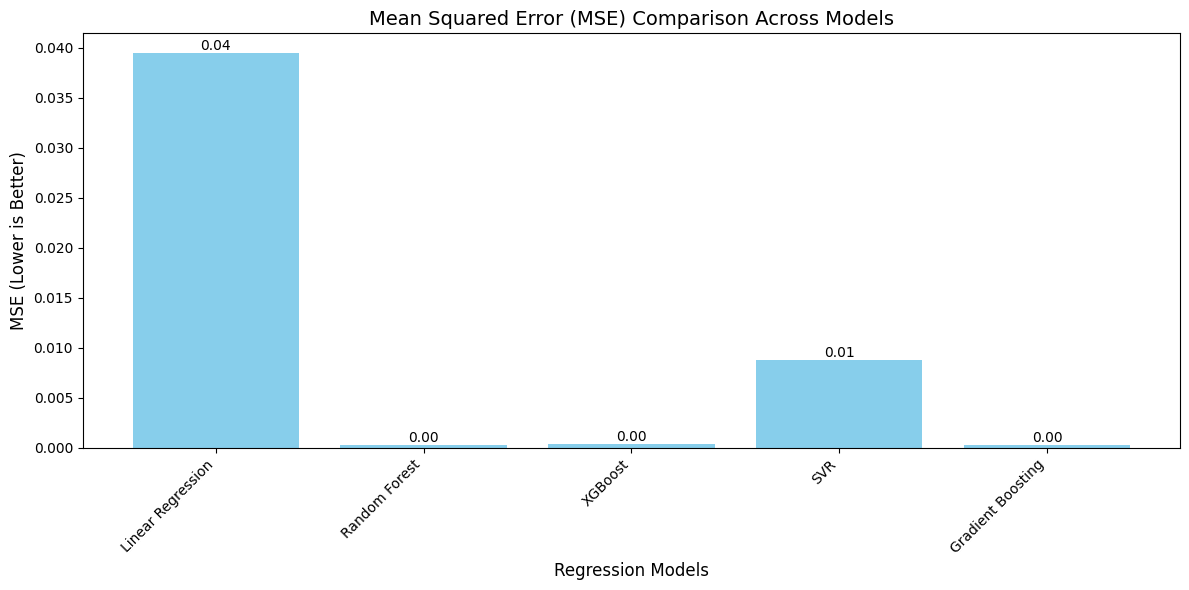

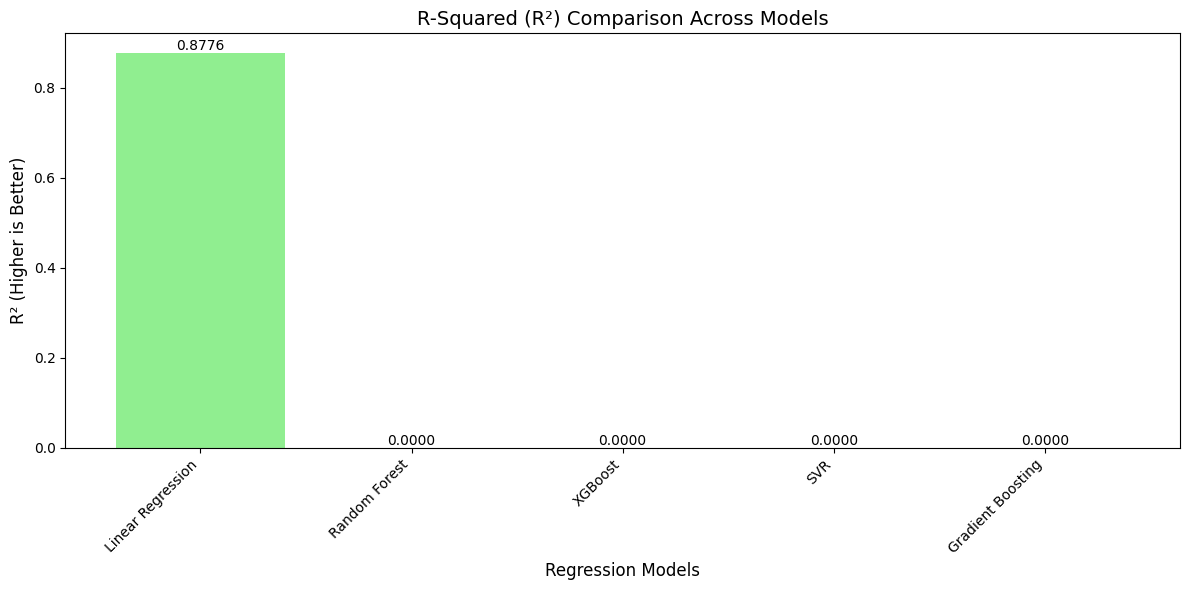


Model Performance Comparison:
            Model  Test MSE  Test RMSE  Test R2
Linear Regression  0.039451   0.198623 0.877614
    Random Forest  0.000275   0.016575 0.000000
          XGBoost  0.000436   0.020869 0.000000
              SVR  0.008779   0.093698 0.000000
Gradient Boosting  0.000254   0.015927 0.000000


In [189]:
import matplotlib.pyplot as plt

# Collect all model metrics
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'SVR', 'Gradient Boosting']

# Get metrics from our previous evaluation - using consistent key names
mse_values = [
    lr_metrics.get('Test RMSE', 0)**2,  # Using .get() with default to prevent KeyError
    rf_metrics.get('Test RMSE', 0)**2,
    xgb_metrics.get('Test RMSE', 0)**2,
    svr_metrics.get('Test RMSE', 0)**2,
    gb_metrics.get('Test RMSE', 0)**2
]

r2_values = [
    lr_metrics.get('Test R2', 0),  # Changed to 'Test R2' to match your dictionary
    rf_metrics.get('Test R2', 0),
    xgb_metrics.get('Test R2', 0),
    svr_metrics.get('Test R2', 0),
    gb_metrics.get('Test R2', 0)
]

# Create a consistent metrics dictionary format (recommended)
metrics = {
    'Linear Regression': {
        'Test MSE': mse_values[0],
        'Test R2': r2_values[0]
    },
    'Random Forest': {
        'Test MSE': mse_values[1],
        'Test R2': r2_values[1]
    },
    'XGBoost': {
        'Test MSE': mse_values[2],
        'Test R2': r2_values[2]
    },
    'SVR': {
        'Test MSE': mse_values[3],
        'Test R2': r2_values[3]
    },
    'Gradient Boosting': {
        'Test MSE': mse_values[4],
        'Test R2': r2_values[4]
    }
}

# Plot MSE comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(models, mse_values, color='skyblue')
plt.title('Mean Squared Error (MSE) Comparison Across Models', fontsize=14)
plt.xlabel('Regression Models', fontsize=12)
plt.ylabel('MSE (Lower is Better)', fontsize=12)
plt.xticks(rotation=45, ha="right")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(models, r2_values, color='lightgreen')
plt.title('R-Squared (R²) Comparison Across Models', fontsize=14)
plt.xlabel('Regression Models', fontsize=12)
plt.ylabel('R² (Higher is Better)', fontsize=12)
plt.xticks(rotation=45, ha="right")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print comprehensive comparison table
print("\nModel Performance Comparison:")
comparison_df = pd.DataFrame({
    'Model': models,
    'Test MSE': mse_values,
    'Test RMSE': np.sqrt(mse_values),
    'Test R2': r2_values
}).sort_values('Test R2', ascending=False)
print(comparison_df.to_string(index=False))

#### 2 - Ridge Regression

Ridge Regression (L2 regularization) adds a penalty for large coefficients, which can help prevent overfitting, especially when there are many features.

In [219]:
# 1. Create and train the model
ridge = Ridge(alpha=1.0)  # Default alpha
ridge.fit(X_train, y_train)

# 2. Make predictions
ridge_train_pred = ridge.predict(X_train)
ridge_test_pred = ridge.predict(X_test)

# 3. Calculate performance scores
ridge_train_score = ridge.score(X_train, y_train)
ridge_test_score = ridge.score(X_test, y_test)

# 4. Calculate error metrics
ridge_train_rmse = math.sqrt(mean_squared_error(y_train, ridge_train_pred))
ridge_test_rmse = math.sqrt(mean_squared_error(y_test, ridge_test_pred))
ridge_train_mape = mean_absolute_percentage_error(y_train, ridge_train_pred)
ridge_test_mape = mean_absolute_percentage_error(y_test, ridge_test_pred)

# 5. Print results
print("\nRidge Regression Performance:")
print(f"Training R2: {ridge_train_score:.3f}")
print(f"Testing R2: {ridge_test_score:.3f}")
print(f"Training RMSE: {ridge_train_rmse:.2f}")
print(f"Testing RMSE: {ridge_test_rmse:.2f}")
print(f"Training MAPE: {ridge_train_mape:.2%}")
print(f"Testing MAPE: {ridge_test_mape:.2%}")


Ridge Regression Performance:
Training R2: 0.876
Testing R2: 0.878
Training RMSE: 0.20
Testing RMSE: 0.20
Training MAPE: 6.16%
Testing MAPE: 6.06%


#### 2.1 -  Hyperparameter Tuning Ridge Regression

- Ridge is sensitive to feature scales. Always standardize (StandardScaler) before tuning.

In [222]:
# Define Hyperparameter Grid

alphas = [0.001, 0.01, 0.1, 1, 10, 100]

In [224]:
#Tune Using GridSearchCV (More Control)

ridge = Ridge()
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best alpha and model
best_alpha = grid_search.best_params_['alpha']
best_ridge = grid_search.best_estimator_
print(f"Best alpha (GridSearchCV): {best_alpha:.3f}")

Best alpha (GridSearchCV): 10.000


In [226]:
# Predictions
ridge_train_pred = best_ridge.predict(X_train)
ridge_test_pred = best_ridge.predict(X_test)

# Metrics
ridge_train_score = best_ridge.score(X_train, y_train)
ridge_test_score = best_ridge.score(X_test, y_test)
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_train_pred))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_pred))

print("\nTuned Ridge Regression Performance:")
print(f"Best Alpha: {best_alpha}")
print(f"Training R2: {ridge_train_score:.3f}")
print(f"Testing R2: {ridge_test_score:.3f}")
print(f"Training RMSE: {ridge_train_rmse:.2f}")
print(f"Testing RMSE: {ridge_test_rmse:.2f}")


Tuned Ridge Regression Performance:
Best Alpha: 10
Training R2: 0.876
Testing R2: 0.877
Training RMSE: 0.20
Testing RMSE: 0.20


#### 3 - Random Forest Regression

Random Forest is an ensemble of decision trees, making it more robust by reducing overfitting. It generally provides better performance than a single decision tree.

In [230]:
# 1. Create and train the model
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

# 2. Make predictions
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

# 3. Calculate performance scores
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)

# 4. Calculate error metrics
rf_train_rmse = math.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = math.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_train_mape = mean_absolute_percentage_error(y_train, rf_train_pred)
rf_test_mape = mean_absolute_percentage_error(y_test, rf_test_pred)

# 5. Print results
print("\nRandom Forest Performance:")
print(f"Training R2: {rf_train_score:.3f}")
print(f"Testing R2: {rf_test_score:.3f}")
print(f"Training RMSE: {rf_train_rmse:.2f}")
print(f"Testing RMSE: {rf_test_rmse:.2f}")
print(f"Training MAPE: {rf_train_mape:.2%}")
print(f"Testing MAPE: {rf_test_mape:.2%}")


Random Forest Performance:
Training R2: 1.000
Testing R2: 0.997
Training RMSE: 0.01
Testing RMSE: 0.03
Training MAPE: 0.04%
Testing MAPE: 0.09%


#### 3.1 -  Hyperparameter Tuning Random Forest Regression

- We’ll use GridSearchCV (exhaustive search) to find the best hyperparameters.

In [232]:
# Define the parameter grid  
param_grid = {  
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 5, 10, 20],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt', 0.8]  
}  

# Initialize the model  
rf = RandomForestRegressor(random_state=0)  

# GridSearchCV (5-fold cross-validation)  
grid_search = GridSearchCV(  
    estimator=rf,  
    param_grid=param_grid,  
    cv=5,  
    scoring='neg_mean_squared_error',  # Minimize RMSE  
    n_jobs=-1  # Use all CPU cores  
)  

# Fit to training data  
grid_search.fit(X_train, y_train)  

# Best parameters  
print("Best Hyperparameters:", grid_search.best_params_) 

KeyboardInterrupt: 

In [ ]:
# Train the Optimized Model Use the best parameters  
best_rf = grid_search.best_estimator_  

# Predictions  
rf_train_pred = best_rf.predict(X_train)  
rf_test_pred = best_rf.predict(X_test)  

# Performance metrics  
rf_train_score = best_rf.score(X_train, y_train)  
rf_test_score = best_rf.score(X_test, y_test)  
rf_train_rmse = math.sqrt(mean_squared_error(y_train, rf_train_pred))  
rf_test_rmse = math.sqrt(mean_squared_error(y_test, rf_test_pred))  
rf_train_mape = mean_absolute_percentage_error(y_train, rf_train_pred)  
rf_test_mape = mean_absolute_percentage_error(y_test, rf_test_pred)  

# Print results  
print("\nTuned Random Forest Performance:")  
print(f"Training R2: {rf_train_score:.3f}")  
print(f"Testing R2: {rf_test_score:.3f}")  
print(f"Training RMSE: {rf_train_rmse:.2f}")  
print(f"Testing RMSE: {rf_test_rmse:.2f}")  
print(f"Training MAPE: {rf_train_mape:.2%}")  
print(f"Testing MAPE: {rf_test_mape:.2%}")  

#### 4 - Lasso Regression

Lasso Regression (L1 regularization) similarly penalizes large coefficients but can also set some coefficients to zero, effectively performing feature selection.

In [ ]:
# 1. Create and train the model
lasso = Lasso(alpha=1.0)  # Default alpha
lasso.fit(X_train, y_train)

# 2. Make predictions
lasso_train_pred = lasso.predict(X_train)
lasso_test_pred = lasso.predict(X_test)

# 3. Calculate performance scores
lasso_train_score = lasso.score(X_train, y_train)
lasso_test_score = lasso.score(X_test, y_test)

# 4. Calculate error metrics
lasso_train_rmse = math.sqrt(mean_squared_error(y_train, lasso_train_pred))
lasso_test_rmse = math.sqrt(mean_squared_error(y_test, lasso_test_pred))
lasso_train_mape = mean_absolute_percentage_error(y_train, lasso_train_pred)
lasso_test_mape = mean_absolute_percentage_error(y_test, lasso_test_pred)

# 5. Print results
print("\nLasso Regression Performance:")
print(f"Training R2: {lasso_train_score:.3f}")
print(f"Testing R2: {lasso_test_score:.3f}")
print(f"Training RMSE: {lasso_train_rmse:.2f}")
print(f"Testing RMSE: {lasso_test_rmse:.2f}")
print(f"Training MAPE: {lasso_train_mape:.2%}")
print(f"Testing MAPE: {lasso_test_mape:.2%}")

#### 4.1 -  Hyperparameter Tuning  Lasso Regression

In [ ]:
# Define alpha values to test (log-scale is common)
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]  
}

In [ ]:
# Initialize Lasso
lasso = Lasso(max_iter=10000)  # Increase max_iter for convergence

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=5,                      # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize MSE
    return_train_score=True
)

# Fit to training data
grid_search.fit(X_train, y_train)

In [ ]:
# Get Best Hyperparameters

best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

In [ ]:
# Train final Lasso model with best alpha
best_lasso = Lasso(alpha=best_alpha, max_iter=10000)
best_lasso.fit(X_train, y_train)

# Evaluate (same as your original code)
train_pred = best_lasso.predict(X_train)
test_pred = best_lasso.predict(X_test)

train_score = best_lasso.score(X_train, y_train)
test_score = best_lasso.score(X_test, y_test)

train_rmse = math.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = math.sqrt(mean_squared_error(y_test, test_pred))

print("\nTuned Lasso Performance:")
print(f"Best alpha: {best_alpha}")
print(f"Training R2: {train_score:.3f}")
print(f"Testing R2: {test_score:.3f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

In [ ]:
# Extract results from GridSearchCV
alphas = grid_search.cv_results_['param_alpha'].data
test_scores = -grid_search.cv_results_['mean_test_score']  # Convert back to MSE

# Plot
plt.figure(figsize=(8, 4))
plt.semilogx(alphas, test_scores, marker='o')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Alpha Tuning')
plt.grid()
plt.show()

#### 5 - Decision Tree Regression

Decision Trees partition the feature space into regions and fit simple models in each region. They work well for non-linear data but may overfit if not properly tuned.

In [ ]:
# 1. Create and train the model
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train, y_train)

# 2. Make predictions
dt_train_pred = dt.predict(X_train)
dt_test_pred = dt.predict(X_test)

# 3. Calculate performance scores
dt_train_score = dt.score(X_train, y_train)
dt_test_score = dt.score(X_test, y_test)

# 4. Calculate error metrics
dt_train_rmse = math.sqrt(mean_squared_error(y_train, dt_train_pred))
dt_test_rmse = math.sqrt(mean_squared_error(y_test, dt_test_pred))
dt_train_mape = mean_absolute_percentage_error(y_train, dt_train_pred)
dt_test_mape = mean_absolute_percentage_error(y_test, dt_test_pred)

# 5. Print results
print("\nDecision Tree Performance:")
print(f"Training R2: {dt_train_score:.3f}")
print(f"Testing R2: {dt_test_score:.3f}")
print(f"Training RMSE: {dt_train_rmse:.2f}")
print(f"Testing RMSE: {dt_test_rmse:.2f}")
print(f"Training MAPE: {dt_train_mape:.2%}")
print(f"Testing MAPE: {dt_test_mape:.2%}")

#### 5.1 - Hyperparameter Tuning Decision Tree

In [ ]:
# Define Hyperparameter Grid

param_grid = {
    'max_depth': [3, 5, 7, None],  # None = unlimited
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.8]  # 80% of features
}

In [ ]:
#Initialize Grid Search

dt = DecisionTreeRegressor(random_state=0)
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Maximizes -RMSE (higher is better)
    n_jobs=-1  # Uses all CPU cores
)

In [ ]:
#  Fit and Find Best Parameters

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)



In [ ]:
# Train with Optimized Parameters

best_dt = DecisionTreeRegressor(**best_params, random_state=0)
best_dt.fit(X_train, y_train)

In [ ]:
#Evaluate Performance

# Predictions
dt_train_pred = best_dt.predict(X_train)
dt_test_pred = best_dt.predict(X_test)

# Scores
dt_train_score = best_dt.score(X_train, y_train)
dt_test_score = best_dt.score(X_test, y_test)

# Error Metrics
dt_train_rmse = math.sqrt(mean_squared_error(y_train, dt_train_pred))
dt_test_rmse = math.sqrt(mean_squared_error(y_test, dt_test_pred))
dt_train_mape = mean_absolute_percentage_error(y_train, dt_train_pred)
dt_test_mape = mean_absolute_percentage_error(y_test, dt_test_pred)

# Print Results
print("\nTuned Decision Tree Performance:")
print(f"Training R2: {dt_train_score:.3f}")
print(f"Testing R2: {dt_test_score:.3f}")
print(f"Training RMSE: {dt_train_rmse:.2f}")
print(f"Testing RMSE: {dt_test_rmse:.2f}")
print(f"Training MAPE: {dt_train_mape:.2%}")
print(f"Testing MAPE: {dt_test_mape:.2%}")

#### 6 - K-Nearest Neighbors Regression

KNN Regression makes predictions based on the average of the nearest neighbors in the feature space. It works well for small datasets and when relationships are non-linear.

In [ ]:
# 1. Create and train the model
knn = KNeighborsRegressor(n_neighbors=5)  # Default k=5
knn.fit(X_train, y_train)

# 2. Make predictions
knn_train_pred = knn.predict(X_train)
knn_test_pred = knn.predict(X_test)

# 3. Calculate performance scores
knn_train_score = knn.score(X_train, y_train)
knn_test_score = knn.score(X_test, y_test)

# 4. Calculate error metrics
knn_train_rmse = math.sqrt(mean_squared_error(y_train, knn_train_pred))
knn_test_rmse = math.sqrt(mean_squared_error(y_test, knn_test_pred))
knn_train_mape = mean_absolute_percentage_error(y_train, knn_train_pred)
knn_test_mape = mean_absolute_percentage_error(y_test, knn_test_pred)

# 5. Print results
print("\nKNN Regression Performance:")
print(f"Training R2: {knn_train_score:.3f}")
print(f"Testing R2: {knn_test_score:.3f}")
print(f"Training RMSE: {knn_train_rmse:.2f}")
print(f"Testing RMSE: {knn_test_rmse:.2f}")
print(f"Training MAPE: {knn_train_mape:.2%}")
print(f"Testing MAPE: {knn_test_mape:.2%}")

#### 6.1 -  Hyperparameter Tuning KNN Regression

In [ ]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],  # Test different k values
    'weights': ['uniform', 'distance'],  # Weighting strategies
    'p': [1, 2]                         # Distance metrics (Manhattan/Euclidean)
}

In [ ]:
# Initialize KNN and GridSearchCV
knn = KNeighborsRegressor()
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,               # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize MSE
    verbose=1,
    n_jobs=-1           # Use all CPU cores
)

# Fit to training data
grid_search.fit(X_train, y_train)

In [ ]:
# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Best model
best_knn = grid_search.best_estimator_

In [ ]:
# Predictions
knn_train_pred = best_knn.predict(X_train)
knn_test_pred = best_knn.predict(X_test)

# Performance metrics
knn_train_score = best_knn.score(X_train, y_train)
knn_test_score = best_knn.score(X_test, y_test)
knn_train_rmse = math.sqrt(mean_squared_error(y_train, knn_train_pred))
knn_test_rmse = math.sqrt(mean_squared_error(y_test, knn_test_pred))

print("\nOptimized KNN Performance:")
print(f"Training R2: {knn_train_score:.3f}")
print(f"Testing R2: {knn_test_score:.3f}")
print(f"Training RMSE: {knn_train_rmse:.2f}")
print(f"Testing RMSE: {knn_test_rmse:.2f}")

## Comparing Models Performance 

In [ ]:
# Step 1: Collect the results in a dictionary
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
          'Decision Tree', 'Random Forest', 'KNN Regression']

mse_values = [mse, mse_ridge, mse_lasso, mse_dt, mse_rf, mse_knn]
r2_values = [r2, r2_ridge, r2_lasso, r2_dt, r2_rf, r2_knn]

# Step 2: Plot MSE
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color='blue')
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Step 3: Plot R2
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='green')
plt.title('R-Squared (R2) Comparison')
plt.xlabel('Models')
plt.ylabel('R2')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [ ]:
### - Comparison table

In [ ]:
# Create comparison table
results = pd.DataFrame({
    'Random Forest': rf_metrics,
    'Gradient Boosting': gb_metrics,
    'SVR': svr_metrics
}).T

print("\n\nModel Comparison:")
print(results[['test_r2', 'test_rmse', 'test_mape']].sort_values('test_r2', ascending=False))

In [ ]:
candy_df